# Maestria en Explotacion de datos y Descubrimiento de conocimiento
### Sistemas de información geografica
### Trabajo Practico N°2

# Clasificación por pixel

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
sys.path.append('../lib')

In [37]:
import plot
import sql
import numpy as np

## Constantes globales

In [ ]:
RASTERS_PATH = "../datasets/images"
DATA_PATH    = "../datasets/data"
RESULT_PATH  = "../results"

In [ ]:
DATES = [
    '2020-10-01', 
    '2020-11-01', 
    '2020-12-01',
    '2021-01-01', 
    '2021-02-20', 
    '2021-03-17'
]
RASTER_FILES = [
    '0000000000-0000000000', 
    '0000000000-0000012544'
]

## Funciones helper

In [38]:
flatten = lambda list: np.ndarray.flatten(np.array(list))
raster_path      = lambda path: f'{RASTERS_PATH}/{path}.tif'
raster_date_path = lambda date, file: raster_path(f'{date}/{file}')

data_path        = lambda file: f'{DATA_PATH}/{file}.shp'
result_path      = lambda file: f'{RESULT_PATH}/{file}'


def print_title(title): print(f'\n\n{title}...\n')

def class_statistics(
    raster_paths,
    labels_file  = 'verdad_campo', 
    label_column = 'id', 
    out_file      = 'class_statistics.xml',
    verbose      = 0
):
    
    in_paths = " ".join(raster_paths)
    vec_path = data_path(labels_file)
    out_path = result_path(out_file)
    
    if verbose > 0:
        print_title('Generate class statistics')
        print(f'- In Paths: {in_paths}')
        print(f'- Vec Path: {vec_path}')
        print(f'- Field...: {label_column}')
        print(f'- Out Path: {out_path}\n\n')
    
    !time otbcli_PolygonClassStatistics -in {in_paths} -vec {vec_path} -field {label_column} -out {out_path} > /dev/null
    !head {out_path}
    return out_path


def merge_rasters(source_paths, target_path, verbose = 0):
    !time gdal_merge.py -ot UInt32 -o {target_path} {" ".join(source_paths)}

    if verbose > 0:
        print_title('Merge Rasters')
        for idx, path in enumerate(source_paths):
            print(f'Source path {idx+1}: {path}')
            plot.plot_raster(path)

        print(f'Target path:\n  - {target_path}\n\n')
        plot.plot_raster(target_path)
        

def layer_info(file):
    !ogrinfo -so {data_path(file)}


def layer_table_info(file, table):
    !ogrinfo -so {data_path(file)} {table}


def layer_query(file, query):
    !ogrinfo -dialect sqlite -sql "{query}" {data_path(file)}

Sampling de observaciones:

In [ ]:
def sampling(
    raster_paths,
    class_stat_path,
    out_rates_path, 
    out_sql_path,
    labels_file  = 'verdad_campo',
    label_column = 'id',
    strategy     = 'smallest',
    verbose      = 0
):
    raster_paths = " ".join(raster_paths)

    if verbose > 0:
        print_title('Sampling')
        print(f'- In Paths......: {raster_paths}')
        print(f'- Vec Path......: {data_path(labels_file)}')
        print(f'- Field.........: {label_column}')
        print(f'- Instats Path..: {class_stat_path}')
        print(f'- Strategy......: {strategy}')
        print(f'- Out Rates Path: {result_path(out_rates_path)}')
        print(f'- Out SQL Path..: {result_path(out_sql_path)}\n\n')

    !time otbcli_SampleSelection \
        -in       {raster_paths} \
        -vec      {data_path(labels_file)} \
        -instats  {class_stat_path} \
        -field    {label_column} \
        -strategy {strategy} \
        -outrates {result_path(out_rates_path)} \
        -out      {result_path(out_sql_path)}

def sample_extraction(
    raster_paths,
    out_sql_file,
    label_column = 'id',
    verbose      = 0
):
    if verbose > 0:
        print_title('Sample extraction')
        print(f'- In Paths......: {" ".join(raster_paths)}')
        print(f'- Vec SQL Path..: {result_path(out_sql_file)}')
        print(f'- Field.........: {label_column}\n\n')

    !time otbcli_SampleExtraction \
        -in                   {" ".join(raster_paths)} \
        -vec                  {result_path(out_sql_file)} \
        -field                {label_column} \
        -outfield             prefix \
        -outfield.prefix.name band_

Funciones de visualización:

Funciones para la clasificación:

In [ ]:
def compute_raster_statistics(
    raster_paths,
    stat_file,
    verbose = 0
):
    output_path = result_path(stat_file)

    if verbose > 0:
        print_title('Compute rasters statistics')
        print(f'- Raster Paths: {" ".join(raster_paths)}')
        print(f'- Stats Path : {output_path}\n\n')

    !time otbcli_ComputeImagesStatistics -il {" ".join(raster_paths)} -out.xml {output_path}

    return output_path

In [ ]:
def train_clasifier(
    sql_file,
    stat_file,
    features         = ['band_0', 'band_1', 'band_2', 'band_3', 'band_4', 'band_5', 'band_6'],
    label_column     = 'id',
    out_model_file   = 'dt_model.txt',
    out_cm_file      = 'dt_cm_model.csv',

    clasifier_config = {
        'classifier': 'dt',
        'classifier.dt.max': '10'
    },
    verbose          = 0
):
    features_param = " ".join(features)

    clasifier_params = ''
    for k, v in clasifier_config.items():
        clasifier_params += f' -{k} {v}' 
        
    if verbose > 0:
        print_title(f'Training {clasifier_config["classifier"]} classifier')
        print(f'- SQL Path.............: {result_path(sql_file)}')
        print(f'- Stats Path...........: {result_path(stat_file)}')
        print(f'- Target...............: {label_column}')
        print(f'- Features.............: {features}')
        print(f'- Model Path...........: {result_path(out_model_file)}')
        print(f'- Confusion Matrix Path: {result_path(out_cm_file)}')
        print(f'- Clasifier config.....: {clasifier_params}\n\n')

    !time otbcli_TrainVectorClassifier \
        -io.vd             {result_path(sql_file)} \
        -io.stats          {result_path(stat_file)} \
        -feat              {features_param} \
        -io.out            {result_path(out_model_file)} \
        -io.confmatout     {result_path(out_cm_file)} \
        -cfield            {label_column} \
        {clasifier_params}

In [ ]:
def band_math(
    raster_paths,
    name           = 'ndvi',
    formula        = '(im1b7-im1b3)/(im1b7+im1b3)',
    extension      = '.tif', 
    verbose        = 0
):
    out_path = lambda path: f'{path.split(extension)[0]}_{name}.tif'
    
    if verbose > 0:
        print_title(f'Calculate "{name} = {formula}" formula')

    outputs = []
    for in_raster_path in raster_paths:
        out_raster_path = out_path(in_raster_path)

        if verbose > 0:
            print(f'\n\n- In: {in_raster_path}\n- Out: {out_raster_path}')

        !time otbcli_BandMath \
            -il  {in_raster_path} \
            -out {out_raster_path} \
            -exp "{formula}"
        outputs.append(out_raster_path)
    return outputs

In [12]:
ALL_VEGETATION_INDEXES = [
    'Vegetation:NDVI',
    'Vegetation:TNDVI', 
    'Vegetation:RVI',
    'Vegetation:SAVI',
    'Vegetation:TSAVI', 
    'Vegetation:MSAVI', 
    'Vegetation:MSAVI2',
    'Vegetation:IPVI',
    'Vegetation:LAIFromNDVILog',
    'Vegetation:LAIFromReflLinear',
    'Vegetation:LAIFromNDVIFormo'
]

def compute_index(
    raster_paths,
    indexes     = ALL_VEGETATION_INDEXES,
    out_postfix = 'indexes',
    blue_band   = 1,
    green_band  = 1,
    red_band    = 1,
    nir_band    = 1,
    mir_band    = 1,
    extension   = '.tif', 
    verbose     = 0
):  
    out_path = lambda path: f'{path.split(extension)[0]}_{out_postfix}.tif'

    if verbose > 0:
        print_title(f'Calculate indexes: "{indexes}"')

    for in_raster_path in raster_paths:
        out_raster_path = out_path(in_raster_path)

        if verbose > 0:
            print(f'\n\n- In: {in_raster_path}\n- Out: {out_raster_path}')

        !time otbcli_RadiometricIndices      \
            -channels.blue  {blue_band}      \
            -channels.green {green_band}     \
            -channels.red   {red_band}       \
            -channels.nir   {nir_band}       \
            -channels.mir   {mir_band}       \
            -in             {in_raster_path} \
            -list           {" ".join(indexes)}        \
            -out            {out_raster_path}

In [13]:
def join_rasters(raster_paths, out_file, verbose = 0):
    if verbose > 0:
        print_title(f'Join rasters')
        print(f'- Input Rasters: {" ".join(raster_paths)}')
        print(f'- Output Raster: {" ".join(out_file)}')

    !time otbcli_ConcatenateImages \
        -il {' '.join(raster_paths)} \
        -out {out_file}

## Analisis

In [13]:
!mkdir -p {RESULT_PATH}

Listamos los archivos de datos:

In [14]:
!ls -la {DATA_PATH}/*shp 

-rw-rw-r-- 1 adrian adrian 79252 abr 24  2021 ../datasets/data/departamentos.shp
-rw-rw-r-- 1 adrian adrian 13148 abr 24  2021 ../datasets/data/verdad_campo.shp


Tenemos dos archivos, departamentes de buenos aires y la verdad de campo o poligonos labels. estos poligonos representan un label y cubro una parte de la superficie de las imagenes donde se encuentra esa misma clase.

Veamos que tablas contienen:

In [15]:
layer_info('departamentos')

INFO: Open of `../datasets/data/departamentos.shp'
      using driver `ESRI Shapefile' successful.
1: departamentos (3D Polygon)


In [16]:
layer_info('verdad_campo')

INFO: Open of `../datasets/data/verdad_campo.shp'
      using driver `ESRI Shapefile' successful.
1: verdad_campo (Point)


In [17]:
layer_table_info('verdad_campo', 'verdad_campo')

INFO: Open of `../datasets/data/verdad_campo.shp'
      using driver `ESRI Shapefile' successful.

Layer name: verdad_campo
Metadata:
  DBF_DATE_LAST_UPDATE=2021-04-24
Geometry: Point
Feature Count: 466
Extent: (-65.072036, -35.286969) - (-62.300375, -33.833709)
Layer SRS WKT:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.0174532925199433,
        AUTHORITY["EPSG","9122"]],
    AXIS["Latitude",NORTH],
    AXIS["Longitude",EAST],
    AUTHORITY["EPSG","4326"]]
Data axis to CRS axis mapping: 2,1
in1: String (6.0)
id: Integer64 (10.0)
cultivo: String (10.0)


La capa o archivo de verdad de campo tiene la columna **cultivo** la cual es una columna categorica que tiene las clases en formato string.

In [18]:
layer_query(
    'verdad_campo', 
    "SELECT * FROM verdad_campo LIMIT 2"
)

INFO: Open of `../datasets/data/verdad_campo.shp'
      using driver `ESRI Shapefile' successful.

Layer name: SELECT
Geometry: Point
Feature Count: 2
Extent: (-62.886600, -34.024258) - (-62.878281, -34.022151)
Layer SRS WKT:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.0174532925199433,
        AUTHORITY["EPSG","9122"]],
    AXIS["Latitude",NORTH],
    AXIS["Longitude",EAST],
    AUTHORITY["EPSG","4326"]]
Data axis to CRS axis mapping: 2,1
Geometry Column = GEOMETRY
in1: String (0.0)
id: Integer64 (0.0)
cultivo: String (0.0)
OGRFeature(SELECT):0
  in1 (String) = 014084
  id (Integer64) = 2
  cultivo (String) = MAIZ
  POINT (-62.8865996133436 -34.0221508898355)

OGRFeature(SELECT):1
  in1 (String) = 014084
  id (Integer64) = 2
  cultivo (String) = MAIZ
  POINT (-62.8782807341426 -34.02425833

In [19]:
layer_query(
    'verdad_campo',
    raster_paths,
    name           = 'ndvi',
    formula        = '(im1b7-im1b3)/(im1b7+im1b3)',
    extension      = '.tif', 
    verbose        = 0
):
    """
    SELECT 
        cultivo  AS Cultivo,
        COUNT(*) AS Cantidad
    FROM
        verdad_campo
    GROUP BY
        cultivo
    """
)

INFO: Open of `../datasets/data/verdad_campo.shp'
      using driver `ESRI Shapefile' successful.

Layer name: SELECT
Geometry: None
Feature Count: 5
Layer SRS WKT:
(unknown)
Cultivo: String (0.0)
Cantidad: Integer (0.0)
OGRFeature(SELECT):0
  Cultivo (String) = ALFALFA
  Cantidad (Integer) = 2

OGRFeature(SELECT):1
  Cultivo (String) = CAMPONATUR
  Cantidad (Integer) = 18

OGRFeature(SELECT):2
  Cultivo (String) = GIRASOL
  Cantidad (Integer) = 32

OGRFeature(SELECT):3
  Cultivo (String) = MAIZ
  Cantidad (Integer) = 246

OGRFeature(SELECT):4
  Cultivo (String) = SOJA
  Cantidad (Integer) = 168



In [20]:
layer_query(
    'verdad_campo', 
    """
    SELECT 
        id       AS 'Codigo de cultivo',
        COUNT(*) AS Cantidad
    FROM
        verdad_campo
    GROUP BY
        cultivo
    """
)

INFO: Open of `../datasets/data/verdad_campo.shp'
      using driver `ESRI Shapefile' successful.

Layer name: SELECT
Geometry: None
Feature Count: 5
Layer SRS WKT:
(unknown)
Codigo de cultivo: Integer64 (0.0)
Cantidad: Integer (0.0)
OGRFeature(SELECT):0
  Codigo de cultivo (Integer64) = 10
  Cantidad (Integer) = 2

OGRFeature(SELECT):1
  Codigo de cultivo (Integer64) = 20
  Cantidad (Integer) = 18

OGRFeature(SELECT):2
  Codigo de cultivo (Integer64) = 5
  Cantidad (Integer) = 32

OGRFeature(SELECT):3
  Codigo de cultivo (Integer64) = 2
  Cantidad (Integer) = 246

OGRFeature(SELECT):4
  Codigo de cultivo (Integer64) = 1
  Cantidad (Integer) = 168



Las columnas **id** y **cultivo** sin intercambiables. Es decir que el id representa a cada tipo de cultivo.

### Estadisticas y merge de rasters

A continuacion veamos la cantidad de pixels en la imagen por cada clase. Seria la distribición de probabilidad discreta de la variable categorica **cultivo** para una imagen dada.

Ver: [PolygonClassStatistics](https://www.orfeo-toolbox.org/CookBook/Applications/app_PolygonClassStatistics.html)

In [21]:
class_statistics([raster_date_path('2020-10-01', '0000000000-0000000000')], verbose=1)

Generate class statistics...

- In Paths: ../datasets/images/2020-10-01/0000000000-0000000000.tif

- Vec Path: ../datasets/data/verdad_campo.shp

- Field...: id

- Out Path: ../results/class_statistics.xml

otbcli_PolygonClassStatistics -in  -vec ../datasets/data/verdad_campo.shp  id  0.07s user 0.04s system 56% cpu 0.207 total
<?xml version="1.0" ?>
<GeneralStatistics>
    <Statistic name="samplesPerClass">
        <StatisticMap key="1" value="79" />
        <StatisticMap key="10" value="2" />
        <StatisticMap key="2" value="66" />
        <StatisticMap key="20" value="18" />
        <StatisticMap key="3" value="130" />
        <StatisticMap key="4" value="34" />
        <StatisticMap key="5" value="31" />


'../results/class_statistics.xml'

Vemos una frecuencia muy baja x clase. Esto se debe a que la imagen completa esta compuesta por las dos imagenes dentro de cada directorio de fecha. Por esta cuestión, primero debemos hacer un merge de ambas imagenes para luego calcular estadisticas, clasificar, etc... 

A continuación se hace mer de todos las imagenes(rasters) por fecha: 

0...10...20...30...40...50...60...70...80...90...100 - done.
gdal_merge.py -ot UInt32 -o ../datasets/images/2020-10-01/complete_raster.tif  75.94s user 17.73s system 97% cpu 1:35.95 total


Merge Rasters...

Source path 1: ../datasets/images/2020-10-01/0000000000-0000000000.tif

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 1 Axes>

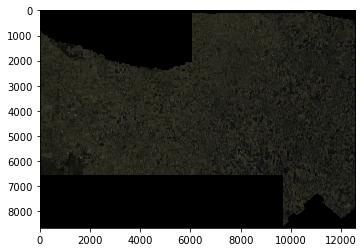

Source path 2: ../datasets/images/2020-10-01/0000000000-0000012544.tif

<Figure size 432x288 with 1 Axes>

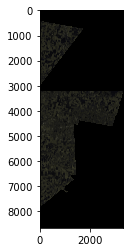

Target path:
  - ../datasets/images/2020-10-01/complete_raster.tif

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 1 Axes>

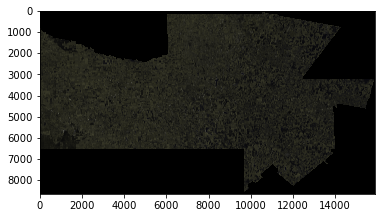

0...10...20...30...40...50...60...70...80...90...100 - done.
gdal_merge.py -ot UInt32 -o ../datasets/images/2020-11-01/complete_raster.tif  76.56s user 18.50s system 99% cpu 1:35.31 total


Merge Rasters...

Source path 1: ../datasets/images/2020-11-01/0000000000-0000000000.tif

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 1 Axes>

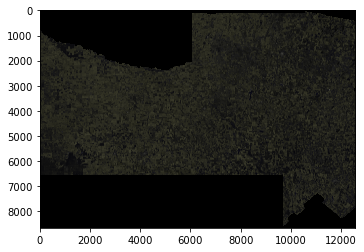

Source path 2: ../datasets/images/2020-11-01/0000000000-0000012544.tif

<Figure size 432x288 with 1 Axes>

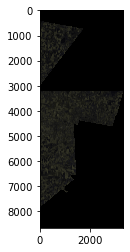

Target path:
  - ../datasets/images/2020-11-01/complete_raster.tif

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 1 Axes>

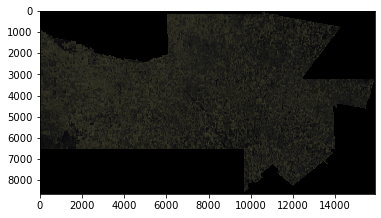

0...10...20...30...40...50...60...70...80...90...100 - done.
gdal_merge.py -ot UInt32 -o ../datasets/images/2020-12-01/complete_raster.tif  74.87s user 18.06s system 95% cpu 1:37.73 total


Merge Rasters...

Source path 1: ../datasets/images/2020-12-01/0000000000-0000000000.tif

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 1 Axes>

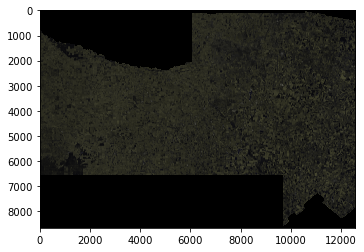

Source path 2: ../datasets/images/2020-12-01/0000000000-0000012544.tif

<Figure size 432x288 with 1 Axes>

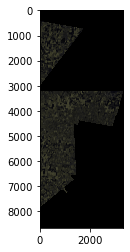

Target path:
  - ../datasets/images/2020-12-01/complete_raster.tif

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 1 Axes>

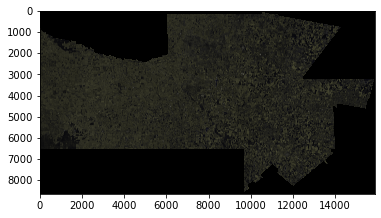

0...10...20...30...40...50...60...70...80...90...100 - done.
gdal_merge.py -ot UInt32 -o ../datasets/images/2021-01-01/complete_raster.tif  75.90s user 17.66s system 95% cpu 1:38.05 total


Merge Rasters...

Source path 1: ../datasets/images/2021-01-01/0000000000-0000000000.tif

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 1 Axes>

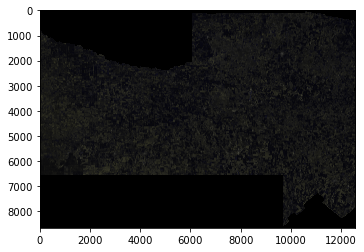

Source path 2: ../datasets/images/2021-01-01/0000000000-0000012544.tif

<Figure size 432x288 with 1 Axes>

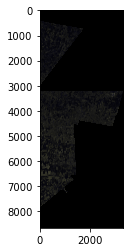

Target path:
  - ../datasets/images/2021-01-01/complete_raster.tif

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 1 Axes>

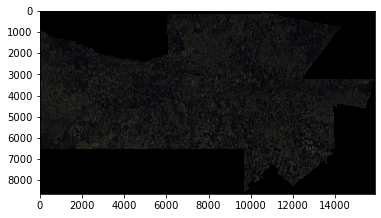

0...10...20...30...40...50...60...70...80...90...100 - done.
gdal_merge.py -ot UInt32 -o ../datasets/images/2021-02-20/complete_raster.tif  76.58s user 17.47s system 94% cpu 1:39.50 total


Merge Rasters...

Source path 1: ../datasets/images/2021-02-20/0000000000-0000000000.tif

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 1 Axes>

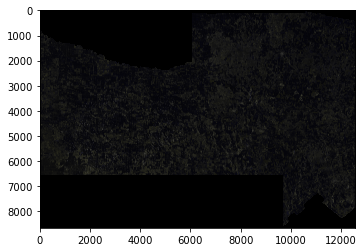

Source path 2: ../datasets/images/2021-02-20/0000000000-0000012544.tif

<Figure size 432x288 with 1 Axes>

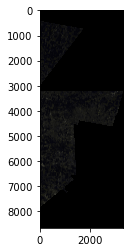

Target path:
  - ../datasets/images/2021-02-20/complete_raster.tif

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 1 Axes>

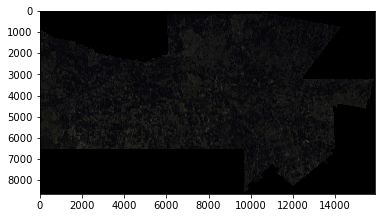

0...10...20...30...40...50...60...70...80...90...100 - done.
gdal_merge.py -ot UInt32 -o ../datasets/images/2021-03-17/complete_raster.tif  78.14s user 19.20s system 93% cpu 1:44.32 total


Merge Rasters...

Source path 1: ../datasets/images/2021-03-17/0000000000-0000000000.tif

<Figure size 432x288 with 1 Axes>

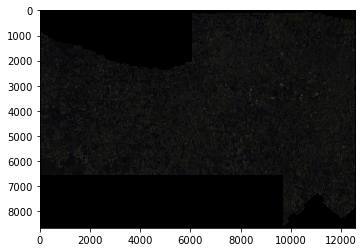

Source path 2: ../datasets/images/2021-03-17/0000000000-0000012544.tif

<Figure size 432x288 with 1 Axes>

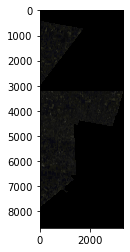

Target path:
  - ../datasets/images/2021-03-17/complete_raster.tif

<Figure size 432x288 with 1 Axes>

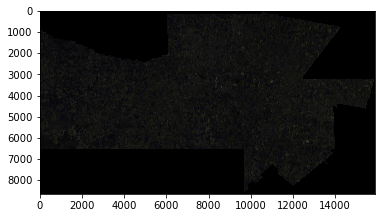

<Figure size 432x288 with 0 Axes>

In [22]:
for date in DATES:
    source_files = [raster_date_path(date, f) for f in RASTER_FILES]
    target_file  =  raster_date_path(date, 'complete_raster')
    merge_rasters(source_files, target_file, verbose = 1)

Ahora validemos si vemos diferencia en las frecuencias:

In [23]:
class_statistics([raster_date_path('2020-10-01', '0000000000-0000000000')], verbose=1)
class_statistics([raster_date_path('2020-10-01', '0000000000-0000012544')], verbose=1)
class_statistics([raster_date_path('2020-10-01', 'complete_raster')], verbose=1)

Generate class statistics...

- In Paths: ../datasets/images/2020-10-01/0000000000-0000000000.tif

- Vec Path: ../datasets/data/verdad_campo.shp

- Field...: id

- Out Path: ../results/class_statistics.xml

otbcli_PolygonClassStatistics -in  -vec ../datasets/data/verdad_campo.shp  id  0.07s user 0.06s system 52% cpu 0.233 total
<?xml version="1.0" ?>
<GeneralStatistics>
    <Statistic name="samplesPerClass">
        <StatisticMap key="1" value="79" />
        <StatisticMap key="10" value="2" />
        <StatisticMap key="2" value="66" />
        <StatisticMap key="20" value="18" />
        <StatisticMap key="3" value="130" />
        <StatisticMap key="4" value="34" />
        <StatisticMap key="5" value="31" />


Generate class statistics...

- In Paths: ../datasets/images/2020-10-01/0000000000-0000012544.tif

- Vec Path: ../datasets/data/verdad_campo.shp

- Field...: id

- Out Path: ../results/class_statistics.xml

otbcli_PolygonClassStatistics -in  -vec ../datasets/data/verdad_campo.shp  id  0.07s user 0.01s system 104% cpu 0.073 total
<?xml version="1.0" ?>
<GeneralStatistics>
    <Statistic name="samplesPerClass">
        <StatisticMap key="1" value="55" />
        <StatisticMap key="2" value="41" />
        <StatisticMap key="3" value="9" />
        <StatisticMap key="5" value="1" />
    </Statistic>
    <Statistic name="samplesPerVector">
        <StatisticMap key="10" value="1" />


Generate class statistics...

- In Paths: ../datasets/images/2020-10-01/complete_raster.tif

- Vec Path: ../datasets/data/verdad_campo.shp

- Field...: id

- Out Path: ../results/class_statistics.xml

otbcli_PolygonClassStatistics -in  -vec ../datasets/data/verdad_campo.shp  id  0.08s user 0.02s system 111% cpu 0.085 total
<?xml version="1.0" ?>
<GeneralStatistics>
    <Statistic name="samplesPerClass">
        <StatisticMap key="1" value="134" />
        <StatisticMap key="10" value="2" />
        <StatisticMap key="2" value="107" />
        <StatisticMap key="20" value="18" />
        <StatisticMap key="3" value="139" />
        <StatisticMap key="4" value="34" />
        <StatisticMap key="5" value="32" />


'../results/class_statistics.xml'

In [24]:
class_statistics([raster_date_path('2021-03-17', '0000000000-0000000000')], verbose=1)
class_statistics([raster_date_path('2021-03-17', '0000000000-0000012544')], verbose=1)
class_statistics([raster_date_path('2021-03-17', 'complete_raster')], verbose=1)

Generate class statistics...

- In Paths: ../datasets/images/2021-03-17/0000000000-0000000000.tif

- Vec Path: ../datasets/data/verdad_campo.shp

- Field...: id

- Out Path: ../results/class_statistics.xml

otbcli_PolygonClassStatistics -in  -vec ../datasets/data/verdad_campo.shp  id  0.08s user 0.03s system 113% cpu 0.100 total
<?xml version="1.0" ?>
<GeneralStatistics>
    <Statistic name="samplesPerClass">
        <StatisticMap key="1" value="79" />
        <StatisticMap key="10" value="2" />
        <StatisticMap key="2" value="66" />
        <StatisticMap key="20" value="18" />
        <StatisticMap key="3" value="130" />
        <StatisticMap key="4" value="34" />
        <StatisticMap key="5" value="31" />


Generate class statistics...

- In Paths: ../datasets/images/2021-03-17/0000000000-0000012544.tif

- Vec Path: ../datasets/data/verdad_campo.shp

- Field...: id

- Out Path: ../results/class_statistics.xml

otbcli_PolygonClassStatistics -in  -vec ../datasets/data/verdad_campo.shp  id  0.06s user 0.01s system 106% cpu 0.066 total
<?xml version="1.0" ?>
<GeneralStatistics>
    <Statistic name="samplesPerClass">
        <StatisticMap key="1" value="55" />
        <StatisticMap key="2" value="41" />
        <StatisticMap key="3" value="9" />
        <StatisticMap key="5" value="1" />
    </Statistic>
    <Statistic name="samplesPerVector">
        <StatisticMap key="10" value="1" />


Generate class statistics...

- In Paths: ../datasets/images/2021-03-17/complete_raster.tif

- Vec Path: ../datasets/data/verdad_campo.shp

- Field...: id

- Out Path: ../results/class_statistics.xml

otbcli_PolygonClassStatistics -in  -vec ../datasets/data/verdad_campo.shp  id  0.06s user 0.02s system 113% cpu 0.079 total
<?xml version="1.0" ?>
<GeneralStatistics>
    <Statistic name="samplesPerClass">
        <StatisticMap key="1" value="134" />
        <StatisticMap key="10" value="2" />
        <StatisticMap key="2" value="107" />
        <StatisticMap key="20" value="18" />
        <StatisticMap key="3" value="139" />
        <StatisticMap key="4" value="34" />
        <StatisticMap key="5" value="32" />


'../results/class_statistics.xml'

**Por que todas las imagenes tiene la misma cantidad de pixeles por clase?**

### Sampling

A continacion sampleamos una cantidad de pixels por clase. De esta forma podemos estratificar las obsercaciones por clase, y asi evitar el desbalanceo de las clases.

Ver: [SampleSelection](https://www.orfeo-toolbox.org/CookBook/Applications/app_SampleSelection.html)

In [25]:
for date in DATES:
    raster_paths = [raster_date_path(date, 'complete_raster')]

    class_stat_path = class_statistics(raster_paths, out_file = f'{date}_class_stat.xml', verbose = 1)

    sampling(
        raster_paths,
        class_stat_path = class_stat_path,
        out_rates_path  = f'{date}_rates.csv',
        out_sql_path    = f'{date}_samples.sqlite',
        verbose         = 1
    )

Generate class statistics...

- In Paths: ../datasets/images/2020-10-01/complete_raster.tif

- Vec Path: ../datasets/data/verdad_campo.shp

- Field...: id

- Out Path: ../results/2020-10-01_class_stat.xml

otbcli_PolygonClassStatistics -in  -vec ../datasets/data/verdad_campo.shp  id  0.06s user 0.03s system 112% cpu 0.080 total
<?xml version="1.0" ?>
<GeneralStatistics>
    <Statistic name="samplesPerClass">
        <StatisticMap key="1" value="134" />
        <StatisticMap key="10" value="2" />
        <StatisticMap key="2" value="107" />
        <StatisticMap key="20" value="18" />
        <StatisticMap key="3" value="139" />
        <StatisticMap key="4" value="34" />
        <StatisticMap key="5" value="32" />


Sampling...

- In Paths......: ../datasets/images/2020-10-01/complete_raster.tif

- Vec Path......: ../datasets/data/verdad_campo.shp

- Field.........: id

- Instats Path..: ../results/2020-10-01_class_stat.xml

- Strategy......: smallest

- Out Rates Path: ../results/2020-10-01_rates.csv

- Out SQL Path..: ../results/2020-10-01_samples.sqlite

2022-06-17 14:32:55 (INFO) SampleSelection: Default RAM limit for OTB is 1024 MB
2022-06-17 14:32:55 (INFO) SampleSelection: GDAL maximum cache size is 1600 MB
2022-06-17 14:32:55 (INFO) SampleSelection: OTB will use at most 128 threads
2022-06-17 14:32:55 (INFO) SampleSelection: Elevation management: setting default height above ellipsoid to 0 meters
2022-06-17 14:32:55 (INFO) SampleSelection: Sampling strategy : fit the number of samples based on the smallest class
2022-06-17 14:32:55 (INFO) SampleSelection: Sampling rates :  className  requiredSamples  totalSamples  rate
1	2	134	0.0149254
10	2	2	1
2	2	107	0.0186916
20	2	18	0.111111
3	2	139	0.0143885
4	2	34	0.0588235
5	2	32	0.0625

2022-06-17 14:32:55 (INFO): Loading metadata from official product
2022-06-17 14:32:55 (INFO): Estimated memory for full processing: 7328.96MB (avail.: 1024 MB), optimal image partitioning: 8 blocks
2022-06-17 14:32:55 (INFO): Estimation will be performed in 12 blocks of 4144x4144 pixels
Selecting position

Generate class statistics...

- In Paths: ../datasets/images/2020-11-01/complete_raster.tif

- Vec Path: ../datasets/data/verdad_campo.shp

- Field...: id

- Out Path: ../results/2020-11-01_class_stat.xml

otbcli_PolygonClassStatistics -in  -vec ../datasets/data/verdad_campo.shp  id  0.07s user 0.02s system 112% cpu 0.079 total
<?xml version="1.0" ?>
<GeneralStatistics>
    <Statistic name="samplesPerClass">
        <StatisticMap key="1" value="134" />
        <StatisticMap key="10" value="2" />
        <StatisticMap key="2" value="107" />
        <StatisticMap key="20" value="18" />
        <StatisticMap key="3" value="139" />
        <StatisticMap key="4" value="34" />
        <StatisticMap key="5" value="32" />


Sampling...

- In Paths......: ../datasets/images/2020-11-01/complete_raster.tif

- Vec Path......: ../datasets/data/verdad_campo.shp

- Field.........: id

- Instats Path..: ../results/2020-11-01_class_stat.xml

- Strategy......: smallest

- Out Rates Path: ../results/2020-11-01_rates.csv

- Out SQL Path..: ../results/2020-11-01_samples.sqlite

2022-06-17 14:32:55 (INFO) SampleSelection: Default RAM limit for OTB is 1024 MB
2022-06-17 14:32:55 (INFO) SampleSelection: GDAL maximum cache size is 1600 MB
2022-06-17 14:32:55 (INFO) SampleSelection: OTB will use at most 128 threads
2022-06-17 14:32:55 (INFO) SampleSelection: Elevation management: setting default height above ellipsoid to 0 meters
2022-06-17 14:32:55 (INFO) SampleSelection: Sampling strategy : fit the number of samples based on the smallest class
2022-06-17 14:32:55 (INFO) SampleSelection: Sampling rates :  className  requiredSamples  totalSamples  rate
1	2	134	0.0149254
10	2	2	1
2	2	107	0.0186916
20	2	18	0.111111
3	2	139	0.0143885
4	2	34	0.0588235
5	2	32	0.0625

2022-06-17 14:32:55 (INFO): Loading metadata from official product
2022-06-17 14:32:55 (INFO): Estimated memory for full processing: 7328.96MB (avail.: 1024 MB), optimal image partitioning: 8 blocks
2022-06-17 14:32:55 (INFO): Estimation will be performed in 12 blocks of 4144x4144 pixels
Selecting position

Generate class statistics...

- In Paths: ../datasets/images/2020-12-01/complete_raster.tif

- Vec Path: ../datasets/data/verdad_campo.shp

- Field...: id

- Out Path: ../results/2020-12-01_class_stat.xml

otbcli_PolygonClassStatistics -in  -vec ../datasets/data/verdad_campo.shp  id  0.06s user 0.03s system 112% cpu 0.079 total
<?xml version="1.0" ?>
<GeneralStatistics>
    <Statistic name="samplesPerClass">
        <StatisticMap key="1" value="134" />
        <StatisticMap key="10" value="2" />
        <StatisticMap key="2" value="107" />
        <StatisticMap key="20" value="18" />
        <StatisticMap key="3" value="139" />
        <StatisticMap key="4" value="34" />
        <StatisticMap key="5" value="32" />


Sampling...

- In Paths......: ../datasets/images/2020-12-01/complete_raster.tif

- Vec Path......: ../datasets/data/verdad_campo.shp

- Field.........: id

- Instats Path..: ../results/2020-12-01_class_stat.xml

- Strategy......: smallest

- Out Rates Path: ../results/2020-12-01_rates.csv

- Out SQL Path..: ../results/2020-12-01_samples.sqlite

2022-06-17 14:32:56 (INFO) SampleSelection: Default RAM limit for OTB is 1024 MB
2022-06-17 14:32:56 (INFO) SampleSelection: GDAL maximum cache size is 1600 MB
2022-06-17 14:32:56 (INFO) SampleSelection: OTB will use at most 128 threads
2022-06-17 14:32:56 (INFO) SampleSelection: Elevation management: setting default height above ellipsoid to 0 meters
2022-06-17 14:32:56 (INFO) SampleSelection: Sampling strategy : fit the number of samples based on the smallest class
2022-06-17 14:32:56 (INFO) SampleSelection: Sampling rates :  className  requiredSamples  totalSamples  rate
1	2	134	0.0149254
10	2	2	1
2	2	107	0.0186916
20	2	18	0.111111
3	2	139	0.0143885
4	2	34	0.0588235
5	2	32	0.0625

2022-06-17 14:32:56 (INFO): Loading metadata from official product
2022-06-17 14:32:56 (INFO): Estimated memory for full processing: 7328.96MB (avail.: 1024 MB), optimal image partitioning: 8 blocks
2022-06-17 14:32:56 (INFO): Estimation will be performed in 12 blocks of 4144x4144 pixels
Selecting position

Generate class statistics...

- In Paths: ../datasets/images/2021-01-01/complete_raster.tif

- Vec Path: ../datasets/data/verdad_campo.shp

- Field...: id

- Out Path: ../results/2021-01-01_class_stat.xml

otbcli_PolygonClassStatistics -in  -vec ../datasets/data/verdad_campo.shp  id  0.08s user 0.01s system 110% cpu 0.084 total
<?xml version="1.0" ?>
<GeneralStatistics>
    <Statistic name="samplesPerClass">
        <StatisticMap key="1" value="134" />
        <StatisticMap key="10" value="2" />
        <StatisticMap key="2" value="107" />
        <StatisticMap key="20" value="18" />
        <StatisticMap key="3" value="139" />
        <StatisticMap key="4" value="34" />
        <StatisticMap key="5" value="32" />


Sampling...

- In Paths......: ../datasets/images/2021-01-01/complete_raster.tif

- Vec Path......: ../datasets/data/verdad_campo.shp

- Field.........: id

- Instats Path..: ../results/2021-01-01_class_stat.xml

- Strategy......: smallest

- Out Rates Path: ../results/2021-01-01_rates.csv

- Out SQL Path..: ../results/2021-01-01_samples.sqlite

2022-06-17 14:32:57 (INFO) SampleSelection: Default RAM limit for OTB is 1024 MB
2022-06-17 14:32:57 (INFO) SampleSelection: GDAL maximum cache size is 1600 MB
2022-06-17 14:32:57 (INFO) SampleSelection: OTB will use at most 128 threads
2022-06-17 14:32:57 (INFO) SampleSelection: Elevation management: setting default height above ellipsoid to 0 meters
2022-06-17 14:32:57 (INFO) SampleSelection: Sampling strategy : fit the number of samples based on the smallest class
2022-06-17 14:32:57 (INFO) SampleSelection: Sampling rates :  className  requiredSamples  totalSamples  rate
1	2	134	0.0149254
10	2	2	1
2	2	107	0.0186916
20	2	18	0.111111
3	2	139	0.0143885
4	2	34	0.0588235
5	2	32	0.0625

2022-06-17 14:32:57 (INFO): Loading metadata from official product
2022-06-17 14:32:57 (INFO): Estimated memory for full processing: 7328.96MB (avail.: 1024 MB), optimal image partitioning: 8 blocks
2022-06-17 14:32:57 (INFO): Estimation will be performed in 12 blocks of 4144x4144 pixels
Selecting position

Generate class statistics...

- In Paths: ../datasets/images/2021-02-20/complete_raster.tif

- Vec Path: ../datasets/data/verdad_campo.shp

- Field...: id

- Out Path: ../results/2021-02-20_class_stat.xml

otbcli_PolygonClassStatistics -in  -vec ../datasets/data/verdad_campo.shp  id  0.06s user 0.03s system 113% cpu 0.076 total
<?xml version="1.0" ?>
<GeneralStatistics>
    <Statistic name="samplesPerClass">
        <StatisticMap key="1" value="134" />
        <StatisticMap key="10" value="2" />
        <StatisticMap key="2" value="107" />
        <StatisticMap key="20" value="18" />
        <StatisticMap key="3" value="139" />
        <StatisticMap key="4" value="34" />
        <StatisticMap key="5" value="32" />


Sampling...

- In Paths......: ../datasets/images/2021-02-20/complete_raster.tif

- Vec Path......: ../datasets/data/verdad_campo.shp

- Field.........: id

- Instats Path..: ../results/2021-02-20_class_stat.xml

- Strategy......: smallest

- Out Rates Path: ../results/2021-02-20_rates.csv

- Out SQL Path..: ../results/2021-02-20_samples.sqlite

2022-06-17 14:32:57 (INFO) SampleSelection: Default RAM limit for OTB is 1024 MB
2022-06-17 14:32:57 (INFO) SampleSelection: GDAL maximum cache size is 1600 MB
2022-06-17 14:32:57 (INFO) SampleSelection: OTB will use at most 128 threads
2022-06-17 14:32:57 (INFO) SampleSelection: Elevation management: setting default height above ellipsoid to 0 meters
2022-06-17 14:32:57 (INFO) SampleSelection: Sampling strategy : fit the number of samples based on the smallest class
2022-06-17 14:32:57 (INFO) SampleSelection: Sampling rates :  className  requiredSamples  totalSamples  rate
1	2	134	0.0149254
10	2	2	1
2	2	107	0.0186916
20	2	18	0.111111
3	2	139	0.0143885
4	2	34	0.0588235
5	2	32	0.0625

2022-06-17 14:32:57 (INFO): Loading metadata from official product
2022-06-17 14:32:57 (INFO): Estimated memory for full processing: 7328.96MB (avail.: 1024 MB), optimal image partitioning: 8 blocks
2022-06-17 14:32:57 (INFO): Estimation will be performed in 12 blocks of 4144x4144 pixels
Selecting position

Generate class statistics...

- In Paths: ../datasets/images/2021-03-17/complete_raster.tif

- Vec Path: ../datasets/data/verdad_campo.shp

- Field...: id

- Out Path: ../results/2021-03-17_class_stat.xml

otbcli_PolygonClassStatistics -in  -vec ../datasets/data/verdad_campo.shp  id  0.06s user 0.04s system 109% cpu 0.092 total
<?xml version="1.0" ?>
<GeneralStatistics>
    <Statistic name="samplesPerClass">
        <StatisticMap key="1" value="134" />
        <StatisticMap key="10" value="2" />
        <StatisticMap key="2" value="107" />
        <StatisticMap key="20" value="18" />
        <StatisticMap key="3" value="139" />
        <StatisticMap key="4" value="34" />
        <StatisticMap key="5" value="32" />


Sampling...

- In Paths......: ../datasets/images/2021-03-17/complete_raster.tif

- Vec Path......: ../datasets/data/verdad_campo.shp

- Field.........: id

- Instats Path..: ../results/2021-03-17_class_stat.xml

- Strategy......: smallest

- Out Rates Path: ../results/2021-03-17_rates.csv

- Out SQL Path..: ../results/2021-03-17_samples.sqlite

2022-06-17 14:32:58 (INFO) SampleSelection: Default RAM limit for OTB is 1024 MB
2022-06-17 14:32:58 (INFO) SampleSelection: GDAL maximum cache size is 1600 MB
2022-06-17 14:32:58 (INFO) SampleSelection: OTB will use at most 128 threads
2022-06-17 14:32:58 (INFO) SampleSelection: Elevation management: setting default height above ellipsoid to 0 meters
2022-06-17 14:32:58 (INFO) SampleSelection: Sampling strategy : fit the number of samples based on the smallest class
2022-06-17 14:32:58 (INFO) SampleSelection: Sampling rates :  className  requiredSamples  totalSamples  rate
1	2	134	0.0149254
10	2	2	1
2	2	107	0.0186916
20	2	18	0.111111
3	2	139	0.0143885
4	2	34	0.0588235
5	2	32	0.0625

2022-06-17 14:32:58 (INFO): Loading metadata from official product
2022-06-17 14:32:58 (INFO): Estimated memory for full processing: 7328.96MB (avail.: 1024 MB), optimal image partitioning: 8 blocks
2022-06-17 14:32:58 (INFO): Estimation will be performed in 12 blocks of 4144x4144 pixels
Selecting position

In [26]:
sql.SQLiteClient.inline_tables_definition(
    path  = result_path('2020-12-01_samples.sqlite'),
    table = 'output'
)

[
    'CREATE TABLE "output" ( "ogc_fid" INTEGER PRIMARY KEY AUTOINCREMENT, "GEOMETRY" BLOB, "in1" VARCHAR(6), "id" BIGINT, "cultivo" VARCHAR(10), "originfid" INTEGER)'
]

In [27]:
sql.SQLiteClient.inline_query(
    path  = result_path('2020-12-01_samples.sqlite'),
    query = """
        SELECT 
            cultivo,
            COUNT(*) AS Cantidad
        FROM
            output
        GROUP BY
            cultivo
        ORDER BY
            Cantidad desc
    """
)

,cultivo,Cantidad
0,SOJA,4
1,MAIZ,4
2,GIRASOL,2
3,CAMPONATUR,2
4,ALFALFA,2


### Extracción de observaciones


En este paso, en base a una capa vectorial (sqlite) y un raster, se genera la tabla **output** dentro del archivos de base de datos sqlite, donde cada fila es un pixel del raster y cada columna es el valor del pixel en cada banda que contenida en el mismo (En nuestro caso, como el raster es una imagen generada con el satelite SENTINEL).

Ver: [SampleExtraction](https://www.orfeo-toolbox.org/CookBook/Applications/app_SampleExtraction.html)

In [28]:
for date in DATES:
    sample_extraction(
        raster_paths = [raster_date_path(date, 'complete_raster')],
        out_sql_file = f'{date}_samples.sqlite',
        verbose      = 1
    )

Sample extraction...

- In Paths......: ../datasets/images/2020-10-01/complete_raster.tif

- Vec SQL Path..: ../results/2020-10-01_samples.sqlite

- Field.........: id

2022-06-17 14:32:58 (INFO) SampleExtraction: Default RAM limit for OTB is 1024 MB
2022-06-17 14:32:58 (INFO) SampleExtraction: GDAL maximum cache size is 1600 MB
2022-06-17 14:32:58 (INFO) SampleExtraction: OTB will use at most 128 threads
2022-06-17 14:32:58 (INFO): Loading metadata from official product
2022-06-17 14:32:58 (INFO): Estimated memory for full processing: 10993.6MB (avail.: 1024 MB), optimal image partitioning: 11 blocks
2022-06-17 14:32:58 (INFO): Estimation will be performed in 12 blocks of 15860x722 pixels
Extracting sample values...: 100% [**************************************************] (4s)
otbcli_SampleExtraction -in ../datasets/images/2020-10-01/complete_raster.tif  1.26s user 1.56s system 55% cpu 5.047 total


Sample extraction...

- In Paths......: ../datasets/images/2020-11-01/complete_raster.tif

- Vec SQL Path..: ../results/2020-11-01_samples.sqlite

- Field.........: id

2022-06-17 14:33:04 (INFO) SampleExtraction: Default RAM limit for OTB is 1024 MB
2022-06-17 14:33:04 (INFO) SampleExtraction: GDAL maximum cache size is 1600 MB
2022-06-17 14:33:04 (INFO) SampleExtraction: OTB will use at most 128 threads
2022-06-17 14:33:04 (INFO): Loading metadata from official product
2022-06-17 14:33:04 (INFO): Estimated memory for full processing: 10993.6MB (avail.: 1024 MB), optimal image partitioning: 11 blocks
2022-06-17 14:33:04 (INFO): Estimation will be performed in 12 blocks of 15860x722 pixels
Extracting sample values...: 100% [**************************************************] (4s)
otbcli_SampleExtraction -in ../datasets/images/2020-11-01/complete_raster.tif  1.37s user 1.43s system 56% cpu 4.997 total


Sample extraction...

- In Paths......: ../datasets/images/2020-12-01/complete_raster.tif

- Vec SQL Path..: ../results/2020-12-01_samples.sqlite

- Field.........: id

2022-06-17 14:33:09 (INFO) SampleExtraction: Default RAM limit for OTB is 1024 MB
2022-06-17 14:33:09 (INFO) SampleExtraction: GDAL maximum cache size is 1600 MB
2022-06-17 14:33:09 (INFO) SampleExtraction: OTB will use at most 128 threads
2022-06-17 14:33:09 (INFO): Loading metadata from official product
2022-06-17 14:33:09 (INFO): Estimated memory for full processing: 10993.6MB (avail.: 1024 MB), optimal image partitioning: 11 blocks
2022-06-17 14:33:09 (INFO): Estimation will be performed in 12 blocks of 15860x722 pixels
Extracting sample values...: 100% [**************************************************] (4s)
otbcli_SampleExtraction -in ../datasets/images/2020-12-01/complete_raster.tif  1.31s user 1.56s system 56% cpu 5.070 total


Sample extraction...

- In Paths......: ../datasets/images/2021-01-01/complete_raster.tif

- Vec SQL Path..: ../results/2021-01-01_samples.sqlite

- Field.........: id

2022-06-17 14:33:14 (INFO) SampleExtraction: Default RAM limit for OTB is 1024 MB
2022-06-17 14:33:14 (INFO) SampleExtraction: GDAL maximum cache size is 1600 MB
2022-06-17 14:33:14 (INFO) SampleExtraction: OTB will use at most 128 threads
2022-06-17 14:33:14 (INFO): Loading metadata from official product
2022-06-17 14:33:14 (INFO): Estimated memory for full processing: 10993.6MB (avail.: 1024 MB), optimal image partitioning: 11 blocks
2022-06-17 14:33:14 (INFO): Estimation will be performed in 12 blocks of 15860x722 pixels
Extracting sample values...: 100% [**************************************************] (4s)
otbcli_SampleExtraction -in ../datasets/images/2021-01-01/complete_raster.tif  1.43s user 1.54s system 58% cpu 5.093 total


Sample extraction...

- In Paths......: ../datasets/images/2021-02-20/complete_raster.tif

- Vec SQL Path..: ../results/2021-02-20_samples.sqlite

- Field.........: id

2022-06-17 14:33:19 (INFO) SampleExtraction: Default RAM limit for OTB is 1024 MB
2022-06-17 14:33:19 (INFO) SampleExtraction: GDAL maximum cache size is 1600 MB
2022-06-17 14:33:19 (INFO) SampleExtraction: OTB will use at most 128 threads
2022-06-17 14:33:19 (INFO): Loading metadata from official product
2022-06-17 14:33:19 (INFO): Estimated memory for full processing: 10993.6MB (avail.: 1024 MB), optimal image partitioning: 11 blocks
2022-06-17 14:33:19 (INFO): Estimation will be performed in 12 blocks of 15860x722 pixels
Extracting sample values...: 100% [**************************************************] (4s)
otbcli_SampleExtraction -in ../datasets/images/2021-02-20/complete_raster.tif  1.34s user 1.65s system 58% cpu 5.078 total


Sample extraction...

- In Paths......: ../datasets/images/2021-03-17/complete_raster.tif

- Vec SQL Path..: ../results/2021-03-17_samples.sqlite

- Field.........: id

2022-06-17 14:33:25 (INFO) SampleExtraction: Default RAM limit for OTB is 1024 MB
2022-06-17 14:33:25 (INFO) SampleExtraction: GDAL maximum cache size is 1600 MB
2022-06-17 14:33:25 (INFO) SampleExtraction: OTB will use at most 128 threads
2022-06-17 14:33:25 (INFO): Loading metadata from official product
2022-06-17 14:33:25 (INFO): Estimated memory for full processing: 10993.6MB (avail.: 1024 MB), optimal image partitioning: 11 blocks
2022-06-17 14:33:25 (INFO): Estimation will be performed in 12 blocks of 15860x722 pixels
Extracting sample values...: 100% [**************************************************] (4s)
otbcli_SampleExtraction -in ../datasets/images/2021-03-17/complete_raster.tif  1.37s user 1.45s system 62% cpu 4.524 total


In [31]:
sql.SQLiteClient.inline_tables_definition(
    path  = result_path('2020-12-01_samples.sqlite'),
    table = 'output'
)

[
    'CREATE TABLE "output" ( "ogc_fid" INTEGER PRIMARY KEY AUTOINCREMENT, "GEOMETRY" BLOB, "in1" VARCHAR(6), "id" BIGINT, "cultivo" VARCHAR(10), "originfid" INTEGER, "band_0" FLOAT, "band_1" FLOAT, "band_2" FLOAT, "band_3" FLOAT, "band_4" FLOAT, "band_5" FLOAT, "band_6" FLOAT)'
]

In [32]:
sql.SQLiteClient.inline_query(
    path  = result_path('2020-12-01_samples.sqlite'),
    query = """
    SELECT
        id, cultivo, band_0, band_1, band_2, band_3, band_4, band_5, band_6
    FROM
        output
    """
)

,id,cultivo,band_0,band_1,band_2,band_3,band_4,band_5,band_6
0,1,SOJA,0.11030,0.14470,0.20530,0.2969,0.31280,0.44280,0.36000
1,2,MAIZ,0.08325,0.11240,0.15930,0.2303,0.24250,0.32375,0.27785
2,3,MAIZ,0.05295,0.07570,0.08695,0.2649,0.27645,0.27160,0.19525
3,5,GIRASOL,0.06445,0.10185,0.09960,0.3870,0.39970,0.29215,0.19620
4,20,CAMPONATUR,0.07070,0.10540,0.12120,0.2734,0.29410,0.32350,0.25000
5,20,CAMPONATUR,0.11770,0.15900,0.20000,0.3115,0.33135,0.37915,0.29460
6,4,SOJA,0.09440,0.12720,0.17160,0.2770,0.30390,0.37730,0.32870
7,5,GIRASOL,0.07450,0.10380,0.12310,0.2787,0.29680,0.33140,0.26365
8,3,MAIZ,0.01480,0.04590,0.01800,0.4756,0.47240,0.18260,0.08500
9,2,MAIZ,0.10005,0.12400,0.17030,0.2441,0.25575,0.40510,0.33370


### ComputeImageStatistics


Ver: [ComputeImageStatistics](https://www.orfeo-toolbox.org/CookBook/Applications/app_ComputeImagesStatistics.html)

In [33]:
for date in DATES:
    compute_raster_statistics(
        raster_paths = [raster_date_path(date, 'complete_raster')],
        stat_file    = f'{date}_norm_raster_stat.xml',
        verbose      = 1
    )

Compute rasters statistics...

- Raster Paths: ../datasets/images/2020-10-01/complete_raster.tif

- Stats Path : ../results/2020-10-01_norm_raster_stat.xml

2022-06-17 14:36:42 (INFO) ComputeImagesStatistics: Default RAM limit for OTB is 1024 MB
2022-06-17 14:36:42 (INFO) ComputeImagesStatistics: GDAL maximum cache size is 1600 MB
2022-06-17 14:36:42 (INFO) ComputeImagesStatistics: OTB will use at most 128 threads
2022-06-17 14:36:42 (INFO): Loading metadata from official product
2022-06-17 14:36:42 (INFO): Estimated memory for full processing: 10993.6MB (avail.: 1024 MB), optimal image partitioning: 11 blocks
2022-06-17 14:36:42 (INFO): Estimation will be performed in 12 blocks of 15860x722 pixels
Processing Image (1/1): 100% [**************************************************] (4s)
Output parameters value:
out.mean: [0.079486, 0.105772, 0.134994, 0.251863, 0.259304, 0.321531, 0.25522]
out.min: [0.0001, 0.0063, 0.0009, 0.0001, 0.0001, 0.0042, 0.0029]
out.max: [1.0088, 1.1228, 1.2356, 1.2884, 0.88735, 0.90225, 0.9506]
out.std: [0.0272121, 0.0306367, 0.0473926, 0.0502634, 0.0507456, 0.0778327, 0.0759153]

otbcli_ComputeImagesStatistics -il 

Compute rasters statistics...

- Raster Paths: ../datasets/images/2020-11-01/complete_raster.tif

- Stats Path : ../results/2020-11-01_norm_raster_stat.xml

2022-06-17 14:36:47 (INFO) ComputeImagesStatistics: Default RAM limit for OTB is 1024 MB
2022-06-17 14:36:47 (INFO) ComputeImagesStatistics: GDAL maximum cache size is 1600 MB
2022-06-17 14:36:47 (INFO) ComputeImagesStatistics: OTB will use at most 128 threads
2022-06-17 14:36:47 (INFO): Loading metadata from official product
2022-06-17 14:36:47 (INFO): Estimated memory for full processing: 10993.6MB (avail.: 1024 MB), optimal image partitioning: 11 blocks
2022-06-17 14:36:47 (INFO): Estimation will be performed in 12 blocks of 15860x722 pixels
Processing Image (1/1): 100% [**************************************************] (3s)
Output parameters value:
out.mean: [0.077316, 0.104465, 0.127616, 0.253876, 0.265029, 0.318965, 0.255314]
out.min: [0.0001, 0.0001, 0.0001, 0.0014, 0.0001, 0.0019, 0.0013]
out.max: [1.848, 1.8208, 1.72, 1.6248, 1.5872, 1.3226, 1.5124]
out.std: [0.025387, 0.0274923, 0.0468042, 0.050141, 0.0507984, 0.0813999, 0.0845822]

otbcli_ComputeImagesStatistics -il  -out.

Compute rasters statistics...

- Raster Paths: ../datasets/images/2020-12-01/complete_raster.tif

- Stats Path : ../results/2020-12-01_norm_raster_stat.xml

2022-06-17 14:36:50 (INFO) ComputeImagesStatistics: Default RAM limit for OTB is 1024 MB
2022-06-17 14:36:50 (INFO) ComputeImagesStatistics: GDAL maximum cache size is 1600 MB
2022-06-17 14:36:50 (INFO) ComputeImagesStatistics: OTB will use at most 128 threads
2022-06-17 14:36:50 (INFO): Loading metadata from official product
2022-06-17 14:36:50 (INFO): Estimated memory for full processing: 10993.6MB (avail.: 1024 MB), optimal image partitioning: 11 blocks
2022-06-17 14:36:50 (INFO): Estimation will be performed in 12 blocks of 15860x722 pixels
Processing Image (1/1): 100% [**************************************************] (3s)
Output parameters value:
out.mean: [0.0819938, 0.114135, 0.143706, 0.284331, 0.295263, 0.339276, 0.266309]
out.min: [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.00265, 0.0021]
out.max: [1.9408, 1.8096, 1.7176, 1.6052, 1.5974, 1.29595, 1.485]
out.std: [0.0269167, 0.0304293, 0.0510517, 0.0510848, 0.0513198, 0.0730549, 0.0757679]

otbcli_ComputeImagesStatistics -il

Compute rasters statistics...

- Raster Paths: ../datasets/images/2021-01-01/complete_raster.tif

- Stats Path : ../results/2021-01-01_norm_raster_stat.xml

2022-06-17 14:36:53 (INFO) ComputeImagesStatistics: Default RAM limit for OTB is 1024 MB
2022-06-17 14:36:53 (INFO) ComputeImagesStatistics: GDAL maximum cache size is 1600 MB
2022-06-17 14:36:53 (INFO) ComputeImagesStatistics: OTB will use at most 128 threads
2022-06-17 14:36:53 (INFO): Loading metadata from official product
2022-06-17 14:36:53 (INFO): Estimated memory for full processing: 10993.6MB (avail.: 1024 MB), optimal image partitioning: 11 blocks
2022-06-17 14:36:53 (INFO): Estimation will be performed in 12 blocks of 15860x722 pixels
Processing Image (1/1): 100% [**************************************************] (3s)
Output parameters value:
out.mean: [0.0527389, 0.0828316, 0.080859, 0.32603, 0.340943, 0.261331, 0.174473]
out.min: [0.0001, 0.0001, 0.0007, 0.0027, 0.001, 0.00165, 0.00155]
out.max: [1.8528, 1.7408, 1.6672, 1.568, 1.5194, 1.312, 1.5121]
out.std: [0.0234102, 0.0258292, 0.0431831, 0.0906783, 0.0911687, 0.0595638, 0.0656748]

otbcli_ComputeImagesStatistics -il  

Compute rasters statistics...

- Raster Paths: ../datasets/images/2021-02-20/complete_raster.tif

- Stats Path : ../results/2021-02-20_norm_raster_stat.xml

2022-06-17 14:36:57 (INFO) ComputeImagesStatistics: Default RAM limit for OTB is 1024 MB
2022-06-17 14:36:57 (INFO) ComputeImagesStatistics: GDAL maximum cache size is 1600 MB
2022-06-17 14:36:57 (INFO) ComputeImagesStatistics: OTB will use at most 128 threads
2022-06-17 14:36:57 (INFO): Loading metadata from official product
2022-06-17 14:36:57 (INFO): Estimated memory for full processing: 10993.6MB (avail.: 1024 MB), optimal image partitioning: 11 blocks
2022-06-17 14:36:57 (INFO): Estimation will be performed in 12 blocks of 15860x722 pixels
Processing Image (1/1): 100% [**************************************************] (3s)
Output parameters value:
out.mean: [0.0427842, 0.0683798, 0.0630044, 0.325853, 0.342392, 0.227265, 0.140894]
out.min: [0.0001, 0.0001, 0.0006, 0.0001, 0.0001, 0.0015, 0.0012]
out.max: [1.0528, 1.1312, 1.2112, 1.2312, 0.9017, 0.9353, 0.9853]
out.std: [0.022535, 0.025289, 0.0390887, 0.10535, 0.106354, 0.0540611, 0.0593879]

otbcli_ComputeImagesStatistics -il  -o

Compute rasters statistics...

- Raster Paths: ../datasets/images/2021-03-17/complete_raster.tif

- Stats Path : ../results/2021-03-17_norm_raster_stat.xml

2022-06-17 14:37:00 (INFO) ComputeImagesStatistics: Default RAM limit for OTB is 1024 MB
2022-06-17 14:37:00 (INFO) ComputeImagesStatistics: GDAL maximum cache size is 1600 MB
2022-06-17 14:37:00 (INFO) ComputeImagesStatistics: OTB will use at most 128 threads
2022-06-17 14:37:00 (INFO): Loading metadata from official product
2022-06-17 14:37:00 (INFO): Estimated memory for full processing: 10993.6MB (avail.: 1024 MB), optimal image partitioning: 11 blocks
2022-06-17 14:37:00 (INFO): Estimation will be performed in 12 blocks of 15860x722 pixels
Processing Image (1/1): 100% [**************************************************] (3s)
Output parameters value:
out.mean: [0.0394666, 0.0660235, 0.0673456, 0.257657, 0.271254, 0.222137, 0.148719]
out.min: [0.0001, 0.0001, 0.0002, 0.003, 0.00095, 0.0014, 0.0012]
out.max: [0.888, 0.8864, 0.9392, 0.932, 0.6501, 1.0793, 1.2956]
out.std: [0.0163246, 0.0185411, 0.0304052, 0.0886013, 0.0900108, 0.0484511, 0.0544197]

otbcli_ComputeImagesStatistics -il 

## Clasificacion por pixels


Ver: [TrainVectorClassifier](https://www.orfeo-toolbox.org/CookBook/Applications/app_TrainVectorClassifier.html)

In [34]:
for date in DATES:
    train_clasifier(
        sql_file         = f'{date}_samples.sqlite',
        stat_file        = f'{date}_norm_raster_stat.xml',
        out_model_file   = f'{date}_dt_model.txt',
        out_cm_file      = f'{date}_dt_cm_model.csv',
        verbose          = 1,
        clasifier_config = {
            'classifier': 'dt',
            'classifier.dt.min': 1,
            'classifier.dt.max': 10
        }
    )

Training dt classifier...

- SQL Path.............: ../results/2020-10-01_samples.sqlite

- Stats Path...........: ../results/2020-10-01_norm_raster_stat.xml

- Target...............: id

- Features.............: ['band_0', 'band_1', 'band_2', 'band_3', 'band_4', 'band_5', 
'band_6']

- Model Path...........: ../results/2020-10-01_dt_model.txt

- Confusion Matrix Path: ../results/2020-10-01_dt_cm_model.csv

- Clasifier config.....:  -classifier dt -classifier.dt.min 1 -classifier.dt.max 10

2022-06-17 14:37:13 (INFO) TrainVectorClassifier: Default RAM limit for OTB is 1024 MB
2022-06-17 14:37:13 (INFO) TrainVectorClassifier: GDAL maximum cache size is 1600 MB
2022-06-17 14:37:13 (INFO) TrainVectorClassifier: OTB will use at most 128 threads
2022-06-17 14:37:13 (INFO) TrainVectorClassifier: Reading vector file 1/1
2022-06-17 14:37:13 (WARNING) TrainVectorClassifier: The validation set is empty. The performance estimation is done using the input training set in this case.
2022-06-17 14:37:13 (INFO) TrainVectorClassifier: Computing model file : ../results/2020-10-01_dt_model.txt
Training model...: 100% [**************************************************] (0s)
Validation...: 100% [**************************************************] (0s)
2022-06-17 14:37:13 (INFO) TrainVectorClassifier: Predicted list size : 14
2022-06-17 14:37:13 (INFO) TrainVectorClassifier: ValidationLabeledListSample size : 14
2022-06-17 14:37:13 (INFO) TrainVectorClassifier: Training performances:
2022-06

Training dt classifier...

- SQL Path.............: ../results/2020-11-01_samples.sqlite

- Stats Path...........: ../results/2020-11-01_norm_raster_stat.xml

- Target...............: id

- Features.............: ['band_0', 'band_1', 'band_2', 'band_3', 'band_4', 'band_5', 
'band_6']

- Model Path...........: ../results/2020-11-01_dt_model.txt

- Confusion Matrix Path: ../results/2020-11-01_dt_cm_model.csv

- Clasifier config.....:  -classifier dt -classifier.dt.min 1 -classifier.dt.max 10

2022-06-17 14:37:13 (INFO) TrainVectorClassifier: Default RAM limit for OTB is 1024 MB
2022-06-17 14:37:13 (INFO) TrainVectorClassifier: GDAL maximum cache size is 1600 MB
2022-06-17 14:37:13 (INFO) TrainVectorClassifier: OTB will use at most 128 threads
2022-06-17 14:37:13 (INFO) TrainVectorClassifier: Reading vector file 1/1
2022-06-17 14:37:13 (WARNING) TrainVectorClassifier: The validation set is empty. The performance estimation is done using the input training set in this case.
2022-06-17 14:37:13 (INFO) TrainVectorClassifier: Computing model file : ../results/2020-11-01_dt_model.txt
Training model...: 100% [**************************************************] (0s)
Validation...: 100% [**************************************************] (0s)
2022-06-17 14:37:13 (INFO) TrainVectorClassifier: Predicted list size : 14
2022-06-17 14:37:13 (INFO) TrainVectorClassifier: ValidationLabeledListSample size : 14
2022-06-17 14:37:13 (INFO) TrainVectorClassifier: Training performances:
2022-06

Training dt classifier...

- SQL Path.............: ../results/2020-12-01_samples.sqlite

- Stats Path...........: ../results/2020-12-01_norm_raster_stat.xml

- Target...............: id

- Features.............: ['band_0', 'band_1', 'band_2', 'band_3', 'band_4', 'band_5', 
'band_6']

- Model Path...........: ../results/2020-12-01_dt_model.txt

- Confusion Matrix Path: ../results/2020-12-01_dt_cm_model.csv

- Clasifier config.....:  -classifier dt -classifier.dt.min 1 -classifier.dt.max 10

2022-06-17 14:37:13 (INFO) TrainVectorClassifier: Default RAM limit for OTB is 1024 MB
2022-06-17 14:37:13 (INFO) TrainVectorClassifier: GDAL maximum cache size is 1600 MB
2022-06-17 14:37:13 (INFO) TrainVectorClassifier: OTB will use at most 128 threads
2022-06-17 14:37:13 (INFO) TrainVectorClassifier: Reading vector file 1/1
2022-06-17 14:37:13 (WARNING) TrainVectorClassifier: The validation set is empty. The performance estimation is done using the input training set in this case.
2022-06-17 14:37:13 (INFO) TrainVectorClassifier: Computing model file : ../results/2020-12-01_dt_model.txt
Training model...: 100% [**************************************************] (0s)
Validation...: 100% [**************************************************] (0s)
2022-06-17 14:37:13 (INFO) TrainVectorClassifier: Predicted list size : 14
2022-06-17 14:37:13 (INFO) TrainVectorClassifier: ValidationLabeledListSample size : 14
2022-06-17 14:37:13 (INFO) TrainVectorClassifier: Training performances:
2022-06

Training dt classifier...

- SQL Path.............: ../results/2021-01-01_samples.sqlite

- Stats Path...........: ../results/2021-01-01_norm_raster_stat.xml

- Target...............: id

- Features.............: ['band_0', 'band_1', 'band_2', 'band_3', 'band_4', 'band_5', 
'band_6']

- Model Path...........: ../results/2021-01-01_dt_model.txt

- Confusion Matrix Path: ../results/2021-01-01_dt_cm_model.csv

- Clasifier config.....:  -classifier dt -classifier.dt.min 1 -classifier.dt.max 10

2022-06-17 14:37:14 (INFO) TrainVectorClassifier: Default RAM limit for OTB is 1024 MB
2022-06-17 14:37:14 (INFO) TrainVectorClassifier: GDAL maximum cache size is 1600 MB
2022-06-17 14:37:14 (INFO) TrainVectorClassifier: OTB will use at most 128 threads
2022-06-17 14:37:14 (INFO) TrainVectorClassifier: Reading vector file 1/1
2022-06-17 14:37:14 (WARNING) TrainVectorClassifier: The validation set is empty. The performance estimation is done using the input training set in this case.
2022-06-17 14:37:14 (INFO) TrainVectorClassifier: Computing model file : ../results/2021-01-01_dt_model.txt
Training model...: 100% [**************************************************] (0s)
Validation...: 100% [**************************************************] (0s)
2022-06-17 14:37:14 (INFO) TrainVectorClassifier: Predicted list size : 14
2022-06-17 14:37:14 (INFO) TrainVectorClassifier: ValidationLabeledListSample size : 14
2022-06-17 14:37:14 (INFO) TrainVectorClassifier: Training performances:
2022-06

Training dt classifier...

- SQL Path.............: ../results/2021-02-20_samples.sqlite

- Stats Path...........: ../results/2021-02-20_norm_raster_stat.xml

- Target...............: id

- Features.............: ['band_0', 'band_1', 'band_2', 'band_3', 'band_4', 'band_5', 
'band_6']

- Model Path...........: ../results/2021-02-20_dt_model.txt

- Confusion Matrix Path: ../results/2021-02-20_dt_cm_model.csv

- Clasifier config.....:  -classifier dt -classifier.dt.min 1 -classifier.dt.max 10

2022-06-17 14:37:14 (INFO) TrainVectorClassifier: Default RAM limit for OTB is 1024 MB
2022-06-17 14:37:14 (INFO) TrainVectorClassifier: GDAL maximum cache size is 1600 MB
2022-06-17 14:37:14 (INFO) TrainVectorClassifier: OTB will use at most 128 threads
2022-06-17 14:37:14 (INFO) TrainVectorClassifier: Reading vector file 1/1
2022-06-17 14:37:14 (WARNING) TrainVectorClassifier: The validation set is empty. The performance estimation is done using the input training set in this case.
2022-06-17 14:37:14 (INFO) TrainVectorClassifier: Computing model file : ../results/2021-02-20_dt_model.txt
Training model...: 100% [**************************************************] (0s)
Validation...: 100% [**************************************************] (0s)
2022-06-17 14:37:14 (INFO) TrainVectorClassifier: Predicted list size : 14
2022-06-17 14:37:14 (INFO) TrainVectorClassifier: ValidationLabeledListSample size : 14
2022-06-17 14:37:14 (INFO) TrainVectorClassifier: Training performances:
2022-06

Training dt classifier...

- SQL Path.............: ../results/2021-03-17_samples.sqlite

- Stats Path...........: ../results/2021-03-17_norm_raster_stat.xml

- Target...............: id

- Features.............: ['band_0', 'band_1', 'band_2', 'band_3', 'band_4', 'band_5', 
'band_6']

- Model Path...........: ../results/2021-03-17_dt_model.txt

- Confusion Matrix Path: ../results/2021-03-17_dt_cm_model.csv

- Clasifier config.....:  -classifier dt -classifier.dt.min 1 -classifier.dt.max 10

2022-06-17 14:37:14 (INFO) TrainVectorClassifier: Default RAM limit for OTB is 1024 MB
2022-06-17 14:37:14 (INFO) TrainVectorClassifier: GDAL maximum cache size is 1600 MB
2022-06-17 14:37:14 (INFO) TrainVectorClassifier: OTB will use at most 128 threads
2022-06-17 14:37:14 (INFO) TrainVectorClassifier: Reading vector file 1/1
2022-06-17 14:37:14 (WARNING) TrainVectorClassifier: The validation set is empty. The performance estimation is done using the input training set in this case.
2022-06-17 14:37:14 (INFO) TrainVectorClassifier: Computing model file : ../results/2021-03-17_dt_model.txt
Training model...: 100% [**************************************************] (0s)
Validation...: 100% [**************************************************] (0s)
2022-06-17 14:37:14 (INFO) TrainVectorClassifier: Predicted list size : 14
2022-06-17 14:37:14 (INFO) TrainVectorClassifier: ValidationLabeledListSample size : 14
2022-06-17 14:37:14 (INFO) TrainVectorClassifier: Training performances:
2022-06

## Join de campañas de cultivo y calculo de indices

Partiendo de los rasters(.tif) pertenecientes a cada campaña de cultivo (6 en total), calculamos el indice NDVI para cada uno de estos. Luego realizamos la acción **Concat**, la cual realiza un join de todos los rasters. Esto significa que, como resultado tendremos un unico raster con las columnas de los 6 rasters iniciales. Como filas tendremos el mismo numero de pixels que los rasters iniciales. Por ejemplo: dados dos rasters 1 y 2 los cuales tiene 10 filas(pixels) y 1 columna cada uno, al concatenarlos tenemos un unico raster de 10 filas y 2 columna. **Concat** es el análogo al aplicar JOIN en sql.

### 1. Primero calculamos lo indice que creamos necesarios. Estos seran utilizados como features en el paso de clasificación.

In [15]:
raster_paths = [raster_date_path(date, 'complete_raster') for date in DATES]
raster_paths

[
    '../datasets/images/2020-10-01/complete_raster.tif',
    '../datasets/images/2020-11-01/complete_raster.tif',
    '../datasets/images/2020-12-01/complete_raster.tif',
    '../datasets/images/2021-01-01/complete_raster.tif',
    '../datasets/images/2021-02-20/complete_raster.tif',
    '../datasets/images/2021-03-17/complete_raster.tif'
]

<img src="../images/lansat2_bands.png" alt="LANSAT2 Bands" width="800">

**Nota**: Las bandas en los rasters comienzan desde 0 no desde 1.

Ver: [RadiometricIndices](https://www.orfeo-toolbox.org/CookBook/Applications/app_RadiometricIndices.html)

In [13]:
ALL_VEGETATION_INDEXES

'Vegetation:NDVI Vegetation:TNDVI Vegetation:RVI Vegetation:SAVI Vegetation:TSAVI Vegetation:MSAVI Vegetation:MSAVI2 Vegetation:IPVI Vegetation:LAIFromNDVILog Vegetation:LAIFromReflLinear Vegetation:LAIFromNDVIFormo'

In [16]:
compute_index(
    raster_paths,
    indexes     = ALL_VEGETATION_INDEXES,
#    indexes     = 'Vegetation:NDVI',
    out_postfix = 'indexes',
    blue_band   = 1,
    green_band  = 2,
    red_band    = 3,
    nir_band    = 7,
    verbose     = 1
)

Calculate indexes: "Vegetation:NDVI Vegetation:TNDVI Vegetation:RVI Vegetation:SAVI 
Vegetation:TSAVI Vegetation:MSAVI Vegetation:MSAVI2 Vegetation:IPVI Vegetation:LAIFromNDVILog
Vegetation:LAIFromReflLinear Vegetation:LAIFromNDVIFormo"...

- In: ../datasets/images/2020-10-01/complete_raster.tif
- Out: ../datasets/images/2020-10-01/complete_raster_indexes.tif

2022-06-17 15:41:50 (INFO) RadiometricIndices: Default RAM limit for OTB is 1024 MB
2022-06-17 15:41:50 (INFO) RadiometricIndices: GDAL maximum cache size is 1600 MB
2022-06-17 15:41:50 (INFO) RadiometricIndices: OTB will use at most 128 threads
2022-06-17 15:41:50 (INFO): Loading metadata from official product
2022-06-17 15:41:50 (INFO): Estimated memory for full processing: 15181.5MB (avail.: 1024 MB), optimal image partitioning: 15 blocks
2022-06-17 15:41:50 (INFO): File ../datasets/images/2020-10-01/complete_raster_indexes.tif will be written in 16 blocks of 15860x541 pixels
Writing ../datasets/images/2020-10-01/complete_raster_indexes.tif...: 100% [**************************************************] (10s)
otbcli_RadiometricIndices -channels.blue 1 -channels.green 2 -channels.red 3   25.44s user 5.19s system 276% cpu 11.082 total


- In: ../datasets/images/2020-11-01/complete_raster.tif
- Out: ../datasets/images/2020-11-01/complete_raster_indexes.tif

2022-06-17 15:42:01 (INFO) RadiometricIndices: Default RAM limit for OTB is 1024 MB
2022-06-17 15:42:01 (INFO) RadiometricIndices: GDAL maximum cache size is 1600 MB
2022-06-17 15:42:01 (INFO) RadiometricIndices: OTB will use at most 128 threads
2022-06-17 15:42:01 (INFO): Loading metadata from official product
2022-06-17 15:42:01 (INFO): Estimated memory for full processing: 15181.5MB (avail.: 1024 MB), optimal image partitioning: 15 blocks
2022-06-17 15:42:01 (INFO): File ../datasets/images/2020-11-01/complete_raster_indexes.tif will be written in 16 blocks of 15860x541 pixels
Writing ../datasets/images/2020-11-01/complete_raster_indexes.tif...: 100% [**************************************************] (10s)
otbcli_RadiometricIndices -channels.blue 1 -channels.green 2 -channels.red 3   15.05s user 4.60s system 180% cpu 10.909 total


- In: ../datasets/images/2020-12-01/complete_raster.tif
- Out: ../datasets/images/2020-12-01/complete_raster_indexes.tif

2022-06-17 15:42:12 (INFO) RadiometricIndices: Default RAM limit for OTB is 1024 MB
2022-06-17 15:42:12 (INFO) RadiometricIndices: GDAL maximum cache size is 1600 MB
2022-06-17 15:42:12 (INFO) RadiometricIndices: OTB will use at most 128 threads
2022-06-17 15:42:12 (INFO): Loading metadata from official product
2022-06-17 15:42:12 (INFO): Estimated memory for full processing: 15181.5MB (avail.: 1024 MB), optimal image partitioning: 15 blocks
2022-06-17 15:42:12 (INFO): File ../datasets/images/2020-12-01/complete_raster_indexes.tif will be written in 16 blocks of 15860x541 pixels
Writing ../datasets/images/2020-12-01/complete_raster_indexes.tif...: 100% [**************************************************] (10s)
otbcli_RadiometricIndices -channels.blue 1 -channels.green 2 -channels.red 3   14.97s user 4.57s system 176% cpu 11.057 total


- In: ../datasets/images/2021-01-01/complete_raster.tif
- Out: ../datasets/images/2021-01-01/complete_raster_indexes.tif

2022-06-17 15:42:23 (INFO) RadiometricIndices: Default RAM limit for OTB is 1024 MB
2022-06-17 15:42:23 (INFO) RadiometricIndices: GDAL maximum cache size is 1600 MB
2022-06-17 15:42:23 (INFO) RadiometricIndices: OTB will use at most 128 threads
2022-06-17 15:42:23 (INFO): Loading metadata from official product
2022-06-17 15:42:23 (INFO): Estimated memory for full processing: 15181.5MB (avail.: 1024 MB), optimal image partitioning: 15 blocks
2022-06-17 15:42:23 (INFO): File ../datasets/images/2021-01-01/complete_raster_indexes.tif will be written in 16 blocks of 15860x541 pixels
Writing ../datasets/images/2021-01-01/complete_raster_indexes.tif...: 100% [**************************************************] (11s)
otbcli_RadiometricIndices -channels.blue 1 -channels.green 2 -channels.red 3   15.12s user 4.46s system 165% cpu 11.811 total


- In: ../datasets/images/2021-02-20/complete_raster.tif
- Out: ../datasets/images/2021-02-20/complete_raster_indexes.tif

2022-06-17 15:42:35 (INFO) RadiometricIndices: Default RAM limit for OTB is 1024 MB
2022-06-17 15:42:35 (INFO) RadiometricIndices: GDAL maximum cache size is 1600 MB
2022-06-17 15:42:35 (INFO) RadiometricIndices: OTB will use at most 128 threads
2022-06-17 15:42:35 (INFO): Loading metadata from official product
2022-06-17 15:42:35 (INFO): Estimated memory for full processing: 15181.5MB (avail.: 1024 MB), optimal image partitioning: 15 blocks
2022-06-17 15:42:35 (INFO): File ../datasets/images/2021-02-20/complete_raster_indexes.tif will be written in 16 blocks of 15860x541 pixels
Writing ../datasets/images/2021-02-20/complete_raster_indexes.tif...: 100% [**************************************************] (12s)
otbcli_RadiometricIndices -channels.blue 1 -channels.green 2 -channels.red 3   15.36s user 4.55s system 160% cpu 12.376 total


- In: ../datasets/images/2021-03-17/complete_raster.tif
- Out: ../datasets/images/2021-03-17/complete_raster_indexes.tif

2022-06-17 15:42:48 (INFO) RadiometricIndices: Default RAM limit for OTB is 1024 MB
2022-06-17 15:42:48 (INFO) RadiometricIndices: GDAL maximum cache size is 1600 MB
2022-06-17 15:42:48 (INFO) RadiometricIndices: OTB will use at most 128 threads
2022-06-17 15:42:48 (INFO): Loading metadata from official product
2022-06-17 15:42:48 (INFO): Estimated memory for full processing: 15181.5MB (avail.: 1024 MB), optimal image partitioning: 15 blocks
2022-06-17 15:42:48 (INFO): File ../datasets/images/2021-03-17/complete_raster_indexes.tif will be written in 16 blocks of 15860x541 pixels
Writing ../datasets/images/2021-03-17/complete_raster_indexes.tif...: 100% [**************************************************] (12s)
otbcli_RadiometricIndices -channels.blue 1 -channels.green 2 -channels.red 3   15.21s user 4.71s system 156% cpu 12.715 total


Como resultado tenemos un nuevo raster por cada campaña de cultivo, cada uno contiene una columna por cada indice calculado.

In [17]:
!gdalinfo {raster_date_path('2020-10-01', 'complete_raster_indexes')}

Driver: GTiff/GeoTIFF
Files: ../datasets/images/2020-10-01/complete_raster_indexes.tif
Size is 15860, 8653
Origin = (-65.117617304426346,-33.815102577054326)
Pixel Size = (0.000179663056824,-0.000179663056824)
Metadata:
  DataType=9
  METADATATYPE=OTB
  OTB_VERSION=8.0.1
  TileHintX=15860
  TileHintY=1
Image Structure Metadata:
  INTERLEAVE=PIXEL
Corner Coordinates:
Upper Left  ( -65.1176173, -33.8151026) 
Lower Left  ( -65.1176173, -35.3697270) 
Upper Right ( -62.2681612, -33.8151026) 
Lower Right ( -62.2681612, -35.3697270) 
Center      ( -63.6928893, -34.5924148) 
Band 1 Block=15860x1 Type=Float32, ColorInterp=Gray
Band 2 Block=15860x1 Type=Float32, ColorInterp=Undefined
Band 3 Block=15860x1 Type=Float32, ColorInterp=Undefined
Band 4 Block=15860x1 Type=Float32, ColorInterp=Undefined
Band 5 Block=15860x1 Type=Float32, ColorInterp=Undefined
Band 6 Block=15860x1 Type=Float32, ColorInterp=Undefined
Band 7 Block=15860x1 Type=Float32, ColorInterp=Undefined
Band 8 Block=15860x1 Type=Float3

### 2. Join de rasters

En este paso vamos a realizar un join de todos los rasters del paso anterior.

In [14]:
join_rasters(
    raster_paths = [raster_date_path(date, 'complete_raster_indexes') for date in DATES],
    out_file     = result_path('complete_rasters_join'),
    verbose      = 1
)

Join rasters...

- Input Rasters: ../datasets/images/2020-10-01/complete_raster_indexes.tif 
../datasets/images/2020-11-01/complete_raster_indexes.tif 
../datasets/images/2020-12-01/complete_raster_indexes.tif 
../datasets/images/2021-01-01/complete_raster_indexes.tif 
../datasets/images/2021-02-20/complete_raster_indexes.tif 
../datasets/images/2021-03-17/complete_raster_indexes.tif

- Output Raster: . . / r e s u l t s / c o m p l e t e _ r a s t e r s _ j o i n

2022-06-17 16:09:03 (INFO) ConcatenateImages: Default RAM limit for OTB is 1024 MB
2022-06-17 16:09:03 (INFO) ConcatenateImages: GDAL maximum cache size is 1600 MB
2022-06-17 16:09:03 (INFO) ConcatenateImages: OTB will use at most 128 threads
2022-06-17 16:09:03 (INFO): Loading metadata from official product
2022-06-17 16:09:03 (INFO): Loading metadata from official product
2022-06-17 16:09:03 (INFO): Loading metadata from official product
2022-06-17 16:09:03 (INFO): Loading metadata from official product
2022-06-17 16:09:03 (INFO): Loading metadata from official product
2022-06-17 16:09:03 (INFO): Loading metadata from official product
2022-06-17 16:09:03 (WARNING) ConcatenateImages: Check filename: no extension detected, using TIF as default.
2022-06-17 16:09:03 (INFO): Estimated memory for full processing: 138206MB (avail.: 1024 MB), optimal image partitioning: 135 blocks
2022-06-17 16:09:03 (INFO): File ../results/complete_rasters_join.tif will be written in 136 blocks of 15860x64 

A continuación podemos observar que el raster consolidado tiene 66 Bandas. El formato raster agregar el nombre **Band** a sus columnas, ya que es la información mas común para este tipo de datos. En nuestro caso estas columnas representan los indices de cada raster de entrada calculado para por cada pixel. Como resultado tendremos un único raster o mapa con todos los indices calculado para cada raster inicial y los pixels del mapa como filas.

In [55]:
!gdalinfo  {result_path('complete_rasters_join.tif')}

Driver: GTiff/GeoTIFF
Files: ../results/complete_rasters_join.tif
Size is 15860, 8653
Origin = (-65.117617304426346,-33.815102577054326)
Pixel Size = (0.000179663056824,-0.000179663056824)
Metadata:
  DataType=9
  METADATATYPE=OTB
  OTB_VERSION=8.0.1
  TileHintX=15860
  TileHintY=1
Image Structure Metadata:
  INTERLEAVE=PIXEL
Corner Coordinates:
Upper Left  ( -65.1176173, -33.8151026) 
Lower Left  ( -65.1176173, -35.3697270) 
Upper Right ( -62.2681612, -33.8151026) 
Lower Right ( -62.2681612, -35.3697270) 
Center      ( -63.6928893, -34.5924148) 
Band 1 Block=15860x1 Type=Float32, ColorInterp=Gray
Band 2 Block=15860x1 Type=Float32, ColorInterp=Undefined
Band 3 Block=15860x1 Type=Float32, ColorInterp=Undefined
Band 4 Block=15860x1 Type=Float32, ColorInterp=Undefined
Band 5 Block=15860x1 Type=Float32, ColorInterp=Undefined
Band 6 Block=15860x1 Type=Float32, ColorInterp=Undefined
Band 7 Block=15860x1 Type=Float32, ColorInterp=Undefined
Band 8 Block=15860x1 Type=Float32, ColorInterp=Undefi

Cuanto pesa el mapa o raster consolidado? 

In [40]:
!du -h {result_path('complete_rasters_join.tif')}

34G	../results/complete_rasters_join.tif


### 3. Clasificacion por pixes usando el raster de indices consolidado

In [41]:
class_stat_path = class_statistics(
    [result_path('complete_rasters_join.tif')], 
    out_file = 'complete_rasters_join_class_stat.xml', 
    verbose = 1
)

Generate class statistics...

- In Paths: ../results/complete_rasters_join.tif

- Vec Path: ../datasets/data/verdad_campo.shp

- Field...: id

- Out Path: ../results/complete_rasters_join_class_stat.xml

otbcli_PolygonClassStatistics -in ../results/complete_rasters_join.tif -vec    0.15s user 0.17s system 109% cpu 0.292 total
<?xml version="1.0" ?>
<GeneralStatistics>
    <Statistic name="samplesPerClass">
        <StatisticMap key="1" value="134" />
        <StatisticMap key="10" value="2" />
        <StatisticMap key="2" value="107" />
        <StatisticMap key="20" value="18" />
        <StatisticMap key="3" value="139" />
        <StatisticMap key="4" value="34" />
        <StatisticMap key="5" value="32" />


In [42]:
sampling(
    [result_path('complete_rasters_join.tif')],
    class_stat_path = class_stat_path,
    out_rates_path  = f'complete_rasters_join_rates.csv',
    out_sql_path    = f'complete_rasters_join_samples.sqlite',
    verbose         = 1,
    strategy        = 'total'
)

Sampling...

- In Paths......: ../results/complete_rasters_join.tif

- Vec Path......: ../datasets/data/verdad_campo.shp

- Field.........: id

- Instats Path..: ../results/complete_rasters_join_class_stat.xml

- Strategy......: total

- Out Rates Path: ../results/complete_rasters_join_rates.csv

- Out SQL Path..: ../results/complete_rasters_join_samples.sqlite

2022-06-17 14:40:49 (INFO) SampleSelection: Default RAM limit for OTB is 1024 MB
2022-06-17 14:40:49 (INFO) SampleSelection: GDAL maximum cache size is 1600 MB
2022-06-17 14:40:49 (INFO) SampleSelection: OTB will use at most 128 threads
2022-06-17 14:40:49 (INFO) SampleSelection: Elevation management: setting default height above ellipsoid to 0 meters
2022-06-17 14:40:49 (INFO) SampleSelection: Sampling strategy: set the total number of samples to generate, use class proportions.
2022-06-17 14:40:49 (INFO) SampleSelection: Sampling rates :  className  requiredSamples  totalSamples  rate
1	288	134	1	[OVERFLOW]
10	4	2	1	[OVERFLOW]
2	230	107	1	[OVERFLOW]
20	39	18	1	[OVERFLOW]
3	298	139	1	[OVERFLOW]
4	73	34	1	[OVERFLOW]
5	69	32	1	[OVERFLOW]

2022-06-17 14:40:49 (WARNING) SampleSelection: 7 cases of overflow detected! (requested number of samples higher than total available samples)
2022-06-17 14:40:49 (INFO): Loading metadata from official product
PeriodicSampler (0x10c0bf0): Needed elemen

In [43]:
sql.SQLiteClient.inline_tables_definition(
    path  = result_path('complete_rasters_join_samples.sqlite'), 
    table = 'output'
)

[
    'CREATE TABLE "output" ( "ogc_fid" INTEGER PRIMARY KEY AUTOINCREMENT, "GEOMETRY" BLOB, "in1" VARCHAR(6), "id" BIGINT, "cultivo" VARCHAR(10), "originfid" INTEGER)'
]

In [44]:
sample_extraction(
    raster_paths = [result_path('complete_rasters_join.tif')],
    out_sql_file = f'complete_rasters_join_samples.sqlite',
    verbose      = 1
)

Sample extraction...

- In Paths......: ../results/complete_rasters_join.tif

- Vec SQL Path..: ../results/complete_rasters_join_samples.sqlite

- Field.........: id

2022-06-17 14:40:51 (INFO) SampleExtraction: Default RAM limit for OTB is 1024 MB
2022-06-17 14:40:51 (INFO) SampleExtraction: GDAL maximum cache size is 1600 MB
2022-06-17 14:40:51 (INFO) SampleExtraction: OTB will use at most 128 threads
2022-06-17 14:40:51 (INFO): Loading metadata from official product
2022-06-17 14:40:51 (INFO): Estimated memory for full processing: 103654MB (avail.: 1024 MB), optimal image partitioning: 102 blocks
2022-06-17 14:40:51 (INFO): Estimation will be performed in 102 blocks of 15860x85 pixels
Extracting sample values...: 100% [**************************************************] (47s)
otbcli_SampleExtraction -in ../results/complete_rasters_join.tif -vec  -field  19.77s user 13.53s system 70% cpu 47.233 total


In [45]:
sql.SQLiteClient.inline_tables_definition(
    path  = result_path('complete_rasters_join_samples.sqlite'), 
    table = 'output'
)

[
    'CREATE TABLE "output" ( "ogc_fid" INTEGER PRIMARY KEY AUTOINCREMENT, "GEOMETRY" BLOB, "in1" VARCHAR(6), "id" BIGINT, "cultivo" VARCHAR(10), "originfid" INTEGER, "band_0" FLOAT, "band_1" FLOAT, "band_2" FLOAT, "band_3" FLOAT, "band_4" FLOAT, "band_5" FLOAT, "band_6" FLOAT, "band_7" FLOAT, "band_8" FLOAT, "band_9" FLOAT, "band_10" FLOAT, "band_11" FLOAT, "band_12" FLOAT, "band_13" FLOAT, "band_14" FLOAT, "band_15" FLOAT, "band_16" FLOAT, "band_17" FLOAT, "band_18" FLOAT, "band_19" FLOAT, "band_20" FLOAT, "band_21" FLOAT, "band_22" FLOAT, "band_23" FLOAT, "band_24" FLOAT, "band_25" FLOAT, "band_26" FLOAT, "band_27" FLOAT, "band_28" FLOAT, "band_29" FLOAT, "band_30" FLOAT, "band_31" FLOAT, "band_32" FLOAT, "band_33" FLOAT, "band_34" FLOAT, "band_35" FLOAT, "band_36" FLOAT, "band_37" FLOAT, "band_38" FLOAT, "band_39" FLOAT, "band_40" FLOAT, "band_41" FLOAT, "band_42" FLOAT, "band_43" FLOAT, "band_44" FLOAT, "band_45" FLOAT, "band_46" FLOAT, "band_47" FLOAT, "band_48" FLOAT, "band_49" FLOAT, "band_50" FLOAT, "band_51" FLOAT, "band_52" FLOAT, "band_53" FLOAT, "band_54" FLOAT, "band_55" FLOAT, "band_56" FLOAT, "band_57" FLOAT, "band_58" FLOAT, "band_59" FLOAT, "band_60" FLOAT, "band_61" FLOAT, "band_62" FLOAT, "band_63" FLOAT, "band_64" FLOAT, "band_65" FLOAT)'
]

In [46]:
sql.SQLiteClient.inline_query(
    path  = result_path('complete_rasters_join_samples.sqlite'),
    query = """
        SELECT 
            cultivo  AS 'Codigo de cultivo',
            COUNT(*) AS 'Cantidad de pixels (Solo aquellos que tiene verdad de campo)'
        FROM
            output
        GROUP BY
            cultivo
        ORDER BY
            'Cantidad de pixels (Solo aquellos que tiene verdad de campo)' desc
    """
)

,Codigo de cultivo,Cantidad de pixels (Solo aquellos que tiene verdad de campo)
0,SOJA,168
1,MAIZ,246
2,GIRASOL,32
3,CAMPONATUR,18
4,ALFALFA,2


In [47]:
compute_raster_statistics(
    raster_paths = [result_path('complete_rasters_join.tif')],
    stat_file    = f'complete_rasters_join_norm_raster_stat.xml',
    verbose      = 1
)

Compute rasters statistics...

- Raster Paths: ../results/complete_rasters_join.tif

- Stats Path : ../results/complete_rasters_join_norm_raster_stat.xml

2022-06-17 14:41:39 (INFO) ComputeImagesStatistics: Default RAM limit for OTB is 1024 MB
2022-06-17 14:41:39 (INFO) ComputeImagesStatistics: GDAL maximum cache size is 1600 MB
2022-06-17 14:41:39 (INFO) ComputeImagesStatistics: OTB will use at most 128 threads
2022-06-17 14:41:39 (INFO): Loading metadata from official product
2022-06-17 14:41:39 (INFO): Estimated memory for full processing: 103654MB (avail.: 1024 MB), optimal image partitioning: 102 blocks
2022-06-17 14:41:39 (INFO): Estimation will be performed in 102 blocks of 15860x85 pixels
Processing Image (1/1): 100% [**************************************************] (1m 05s)
Output parameters value:
out.mean: [0.306923, 0.892729, 1.95258, 0.198544, -1.30331, 0.172297, 0.178309, 0.653462, 0.465861, 0.711262, 0.298612, 0.330887, 0.907383, 2.05194, 0.211162, -1.32604, 0.183164, 0.189871, 0.665444, 0.519692, 0.844552, 0.346353, 0.30659, 0.894816, 1.95246, 0.199373, -1.24265, 0.173829, 0.179681, 0.653295, 0.457237, 0.691169, 0.2985

'../results/complete_rasters_join_norm_raster_stat.xml'

In [48]:
train_clasifier(
    sql_file         = f'complete_rasters_join_samples.sqlite',
    stat_file        = f'complete_rasters_join_norm_raster_stat.xml',
    out_model_file   = f'complete_rasters_join_rf_model.txt',
    out_cm_file      = f'complete_rasters_join_rf_cm_model.csv',
    verbose          = 1,
    features         = [f'band_{idx}' for idx in range(66)],
    clasifier_config = {
        'classifier': 'rf',
        'classifier.rf.min': 1,
        'classifier.rf.max': 10
    }
)

Training rf classifier...

- SQL Path.............: ../results/complete_rasters_join_samples.sqlite

- Stats Path...........: ../results/complete_rasters_join_norm_raster_stat.xml

- Target...............: id

- Features.............: ['band_0', 'band_1', 'band_2', 'band_3', 'band_4', 'band_5', 
'band_6', 'band_7', 'band_8', 'band_9', 'band_10', 'band_11', 'band_12', 'band_13', 
'band_14', 'band_15', 'band_16', 'band_17', 'band_18', 'band_19', 'band_20', 'band_21', 
'band_22', 'band_23', 'band_24', 'band_25', 'band_26', 'band_27', 'band_28', 'band_29', 
'band_30', 'band_31', 'band_32', 'band_33', 'band_34', 'band_35', 'band_36', 'band_37', 
'band_38', 'band_39', 'band_40', 'band_41', 'band_42', 'band_43', 'band_44', 'band_45', 
'band_46', 'band_47', 'band_48', 'band_49', 'band_50', 'band_51', 'band_52', 'band_53', 
'band_54', 'band_55', 'band_56', 'band_57', 'band_58', 'band_59', 'band_60', 'band_61', 
'band_62', 'band_63', 'band_64', 'band_65']

- Model Path...........: ../results/complete_rasters_join_rf_model.txt

- Confusion Matrix Path: ../results/complete_rasters_join_rf_cm_model.csv

- Clasifier config.....:  -classifier rf -classifier.rf.min 1 -classifier.rf.max 10

2022-06-17 14:42:45 (INFO) TrainVectorClassifier: Default RAM limit for OTB is 1024 MB
2022-06-17 14:42:45 (INFO) TrainVectorClassifier: GDAL maximum cache size is 1600 MB
2022-06-17 14:42:45 (INFO) TrainVectorClassifier: OTB will use at most 128 threads
2022-06-17 14:42:45 (INFO) TrainVectorClassifier: Reading vector file 1/1
2022-06-17 14:42:45 (WARNING) TrainVectorClassifier: The validation set is empty. The performance estimation is done using the input training set in this case.
2022-06-17 14:42:45 (INFO) TrainVectorClassifier: Computing model file : ../results/complete_rasters_join_rf_model.txt
Training model...: 100% [**************************************************] (0s)
Validation...: 100% [**************************************************] (0s)
2022-06-17 14:42:45 (INFO) TrainVectorClassifier: Predicted list size : 466
2022-06-17 14:42:45 (INFO) TrainVectorClassifier: ValidationLabeledListSample size : 466
2022-06-17 14:42:45 (INFO) TrainVectorClassifier: Training performa

## Construcción de dataset CSV

A partir de el conjunto completo de pixels que tienen verdad de campo construmimos un dataset en csv, renombrando las columnas para identificar a que indice y campaña de cultivo pertenecen.

In [14]:
df = sql.SQLiteClient.inline_query(
    path  = result_path('complete_rasters_join_samples.sqlite'), 
    query = 'SELECT * FROM output'
)

In [47]:
indexes_columns = flatten([[f'{value.replace("Vegetation:", "")}_{i+1}' for value in ALL_VEGETATION_INDEXES] for i in range(len(DATES))])

band_columns = np.array(list(filter(lambda v: 'band_' in v, df.columns)))

indexes_columns, band_columns

(
    array(['NDVI_1', 'TNDVI_1', 'RVI_1', 'SAVI_1', 'TSAVI_1', 'MSAVI_1',
       'MSAVI2_1', 'IPVI_1', 'LAIFromNDVILog_1', 'LAIFromReflLinear_1',
       'LAIFromNDVIFormo_1', 'NDVI_2', 'TNDVI_2', 'RVI_2', 'SAVI_2',
       'TSAVI_2', 'MSAVI_2', 'MSAVI2_2', 'IPVI_2', 'LAIFromNDVILog_2',
       'LAIFromReflLinear_2', 'LAIFromNDVIFormo_2', 'NDVI_3', 'TNDVI_3',
       'RVI_3', 'SAVI_3', 'TSAVI_3', 'MSAVI_3', 'MSAVI2_3', 'IPVI_3',
       'LAIFromNDVILog_3', 'LAIFromReflLinear_3', 'LAIFromNDVIFormo_3',
       'NDVI_4', 'TNDVI_4', 'RVI_4', 'SAVI_4', 'TSAVI_4', 'MSAVI_4',
       'MSAVI2_4', 'IPVI_4', 'LAIFromNDVILog_4', 'LAIFromReflLinear_4',
       'LAIFromNDVIFormo_4', 'NDVI_5', 'TNDVI_5', 'RVI_5', 'SAVI_5',
       'TSAVI_5', 'MSAVI_5', 'MSAVI2_5', 'IPVI_5', 'LAIFromNDVILog_5',
       'LAIFromReflLinear_5', 'LAIFromNDVIFormo_5', 'NDVI_6', 'TNDVI_6',
       'RVI_6', 'SAVI_6', 'TSAVI_6', 'MSAVI_6', 'MSAVI2_6', 'IPVI_6',
       'LAIFromNDVILog_6', 'LAIFromReflLinear_6', 'LAIFromNDVIFormo_6'],
      dtype='<U19'),
    array(['band_0', 'band_1', 'band_2', 'band_3', 'band_4', 'band_5',
       'band_6', 'band_7', 'band_8', 'band_9', 'band_10', 'band_11',
       'band_12', 'band_13', 'band_14', 'band_15', 'band_16', 'band_17',
       'band_18', 'band_19', 'band_20', 'band_21', 'band_22', 'band_23',
       'band_24', 'band_25', 'band_26', 'band_27', 'band_28', 'band_29',
       'band_30', 'band_31', 'band_32', 'band_33', 'band_34', 'band_35',
       'band_36', 'band_37', 'band_38', 'band_39', 'band_40', 'band_41',
       'band_42', 'band_43', 'band_44', 'band_45', 'band_46', 'band_47',
       'band_48', 'band_49', 'band_50', 'band_51', 'band_52', 'band_53',
       'band_54', 'band_55', 'band_56', 'band_57', 'band_58', 'band_59',
       'band_60', 'band_61', 'band_62', 'band_63', 'band_64', 'band_65'],
      dtype='<U7')
)

In [51]:
rename_def = {k:v for k,v in zip(band_columns, indexes_columns) }
rename_def

{
    'band_0': 'NDVI_1',
    'band_1': 'TNDVI_1',
    'band_2': 'RVI_1',
    'band_3': 'SAVI_1',
    'band_4': 'TSAVI_1',
    'band_5': 'MSAVI_1',
    'band_6': 'MSAVI2_1',
    'band_7': 'IPVI_1',
    'band_8': 'LAIFromNDVILog_1',
    'band_9': 'LAIFromReflLinear_1',
    'band_10': 'LAIFromNDVIFormo_1',
    'band_11': 'NDVI_2',
    'band_12': 'TNDVI_2',
    'band_13': 'RVI_2',
    'band_14': 'SAVI_2',
    'band_15': 'TSAVI_2',
    'band_16': 'MSAVI_2',
    'band_17': 'MSAVI2_2',
    'band_18': 'IPVI_2',
    'band_19': 'LAIFromNDVILog_2',
    'band_20': 'LAIFromReflLinear_2',
    'band_21': 'LAIFromNDVIFormo_2',
    'band_22': 'NDVI_3',
    'band_23': 'TNDVI_3',
    'band_24': 'RVI_3',
    'band_25': 'SAVI_3',
    'band_26': 'TSAVI_3',
    'band_27': 'MSAVI_3',
    'band_28': 'MSAVI2_3',
    'band_29': 'IPVI_3',
    'band_30': 'LAIFromNDVILog_3',
    'band_31': 'LAIFromReflLinear_3',
    'band_32': 'LAIFromNDVIFormo_3',
    'band_33': 'NDVI_4',
    'band_34': 'TNDVI_4',
    'band_35': 'RVI_4',
    'band_36': 'SAVI_4',
    'band_37': 'TSAVI_4',
    'band_38': 'MSAVI_4',
    'band_39': 'MSAVI2_4',
    'band_40': 'IPVI_4',
    'band_41': 'LAIFromNDVILog_4',
    'band_42': 'LAIFromReflLinear_4',
    'band_43': 'LAIFromNDVIFormo_4',
    'band_44': 'NDVI_5',
    'band_45': 'TNDVI_5',
    'band_46': 'RVI_5',
    'band_47': 'SAVI_5',
    'band_48': 'TSAVI_5',
    'band_49': 'MSAVI_5',
    'band_50': 'MSAVI2_5',
    'band_51': 'IPVI_5',
    'band_52': 'LAIFromNDVILog_5',
    'band_53': 'LAIFromReflLinear_5',
    'band_54': 'LAIFromNDVIFormo_5',
    'band_55': 'NDVI_6',
    'band_56': 'TNDVI_6',
    'band_57': 'RVI_6',
    'band_58': 'SAVI_6',
    'band_59': 'TSAVI_6',
    'band_60': 'MSAVI_6',
    'band_61': 'MSAVI2_6',
    'band_62': 'IPVI_6',
    'band_63': 'LAIFromNDVILog_6',
    'band_64': 'LAIFromReflLinear_6',
    'band_65': 'LAIFromNDVIFormo_6'
}

In [60]:
df = df.rename(columns =rename_def)

In [61]:
df.to_csv( result_path('dataset.csv'), encoding='utf-8')

## Predicción

In [17]:
!otbcli_ImageClassifier \
    -in     {result_path('complete_rasters_join.tif')}  \
    -imstat {result_path('complete_rasters_join_norm_raster_stat.xml')} \
    -model  {result_path('complete_rasters_join_rf_model.txt')} \
    -out    {result_path('predict.tif')}

2022-06-23 20:46:18 (INFO) ImageClassifier: Default RAM limit for OTB is 1024 MB
2022-06-23 20:46:18 (INFO) ImageClassifier: GDAL maximum cache size is 1600 MB
2022-06-23 20:46:18 (INFO) ImageClassifier: OTB will use at most 128 threads
2022-06-23 20:46:18 (INFO): Loading metadata from official product
2022-06-23 20:46:18 (INFO) ImageClassifier: Loading model
2022-06-23 20:46:18 (INFO) ImageClassifier: Model loaded
2022-06-23 20:46:18 (INFO) ImageClassifier: Input image normalization activated.
2022-06-23 20:46:18 (INFO) ImageClassifier: mean used: [0.306923, 0.892729, 1.95258, 0.198544, -1.30331, 0.172297, 0.178309, 0.653462, 0.465861, 0.711262, 0.298612, 0.330887, 0.907383, 2.05194, 0.211162, -1.32604, 0.183164, 0.189871, 0.665444, 0.519692, 0.844552, 0.346353, 0.30659, 0.894816, 1.95246, 0.199373, -1.24265, 0.173829, 0.179681, 0.653295, 0.457237, 0.691169, 0.298535, 0.391082, 0.939427, 2.46954, 0.183084, -1.84434, 0.149201, 0.155295, 0.695541, 0.712211, 0.690856, 0.561675, 0.414047,

In [22]:
result_path('complete_rasters_join.tif')

'../results/complete_rasters_join.tif'

In [21]:
result_path('predict.tif')

'../results/predict.tif'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 1 Axes>

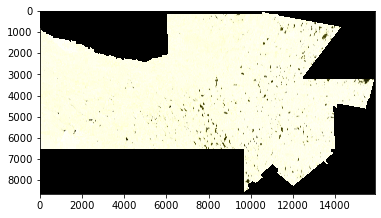

<Figure size 432x288 with 0 Axes>

In [23]:
plot.plot_raster(result_path('complete_rasters_join.tif'))

In [54]:
!gdalinfo {raster_date_path('2020-11-01', 'complete_raster_ndvi')}

Driver: GTiff/GeoTIFF
Files: ../datasets/images/2020-11-01/complete_raster_ndvi.tif
Size is 15860, 8653
Origin = (-65.117617304426346,-33.815102577054326)
Pixel Size = (0.000179663056824,-0.000179663056824)
Metadata:
  DataType=9
  METADATATYPE=OTB
  OTB_VERSION=8.0.1
  TileHintX=15860
  TileHintY=1
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  ( -65.1176173, -33.8151026) 
Lower Left  ( -65.1176173, -35.3697270) 
Upper Right ( -62.2681612, -33.8151026) 
Lower Right ( -62.2681612, -35.3697270) 
Center      ( -63.6928893, -34.5924148) 
Band 1 Block=15860x1 Type=Float32, ColorInterp=Gray


In [53]:
!gdalinfo {result_path('predict.tif')}

Driver: GTiff/GeoTIFF
Files: ../results/predict.tif
Size is 15860, 8653
Origin = (-65.117617304426346,-33.815102577054326)
Pixel Size = (0.000179663056824,-0.000179663056824)
Metadata:
  DataType=9
  METADATATYPE=OTB
  OTB_VERSION=8.0.1
  TileHintX=15860
  TileHintY=1
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  ( -65.1176173, -33.8151026) 
Lower Left  ( -65.1176173, -35.3697270) 
Upper Right ( -62.2681612, -33.8151026) 
Lower Right ( -62.2681612, -35.3697270) 
Center      ( -63.6928893, -34.5924148) 
Band 1 Block=15860x1 Type=Byte, ColorInterp=Gray


In [52]:
# plot.plot_raster(result_path('predict.tif'), bands_by_color = { 'blue': 1}, figsize=(25, 20))